## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import machine learning and stats libraries:
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
# Import:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier




# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Exploratory data analysis

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#observe the different feature type present in the data
df.dtypes


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Here we will observe the distribution of our classes

In [4]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

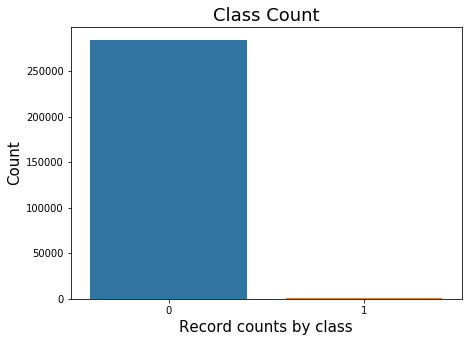

In [5]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
plt.figure(figsize=(7,5))
sns.countplot(df['Class'])
plt.title("Class Count", fontsize=18)
plt.xlabel("Record counts by class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()


Text(0.5, 1.05, 'Time vs Class Distribution')

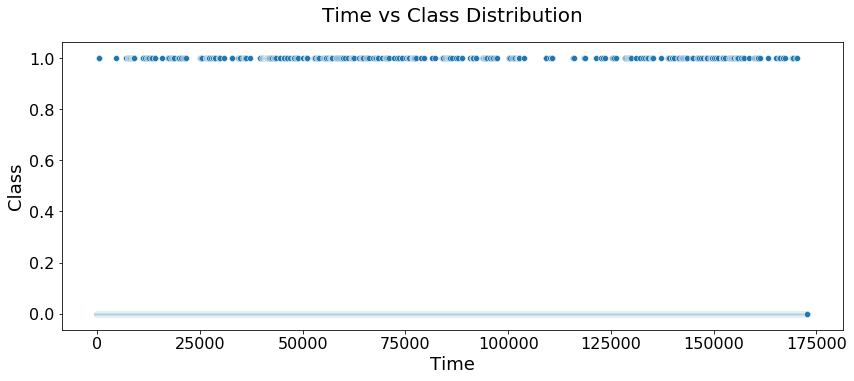

In [6]:
# Create a scatter plot to observe the distribution of classes with time

fig = plt.figure(figsize=(14, 18))
cmap = sns.color_palette('Set2')
plt.subplot(3,1,1)
sns.scatterplot(x=df['Time'], y='Class', palette=cmap, data=df)
plt.xlabel('Time', size=18)
plt.ylabel('Class', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('Time vs Class Distribution', size=20, y=1.05)

Text(0.5, 1.05, 'Amount vs Class Distribution')

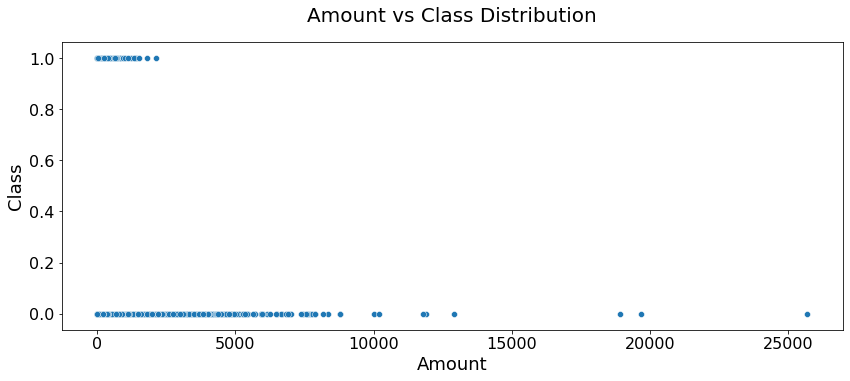

In [7]:
# Create a scatter plot to observe the distribution of classes with Amount

fig = plt.figure(figsize=(14, 18))
cmap = sns.color_palette('Set1')


plt.subplot(3,1,1)
sns.scatterplot(x=df['Amount'], y='Class', palette=cmap, data=df)
plt.xlabel('Amount', size=18)
plt.ylabel('Class', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('Amount vs Class Distribution', size=20, y=1.05)

In [8]:
#As time is given in relative fashion, we will need to use pandas.Timedelta which Represents a duration, the difference between two dates or times.

Delta_Time = pd.to_timedelta(df['Time'], unit='s')
#Create derived columns Mins and hours
df['Time_Day'] = (Delta_Time.dt.components.days).astype(int)
df['Time_Hour'] = (Delta_Time.dt.components.hours).astype(int)
df['Time_Min'] = (Delta_Time.dt.components.minutes).astype(int)

In [9]:
# Drop unnecessary columns
# As we have derived the Day/Hour/Minutes from the time column we will drop Time
df.drop('Time', axis = 1, inplace= True)
#also day/minutes might not be very useful as this is not time series data, we will keep only derived column hour
df.drop(['Time_Day', 'Time_Min'], axis = 1, inplace= True)


### Splitting the data into train & test data

In [10]:
y= df['Class'] #class variable
X = df.drop(['Class'], axis=1)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.20)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [12]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
396
96


### Plotting the distribution of a variable

In [13]:
cols = list(X.columns.values)

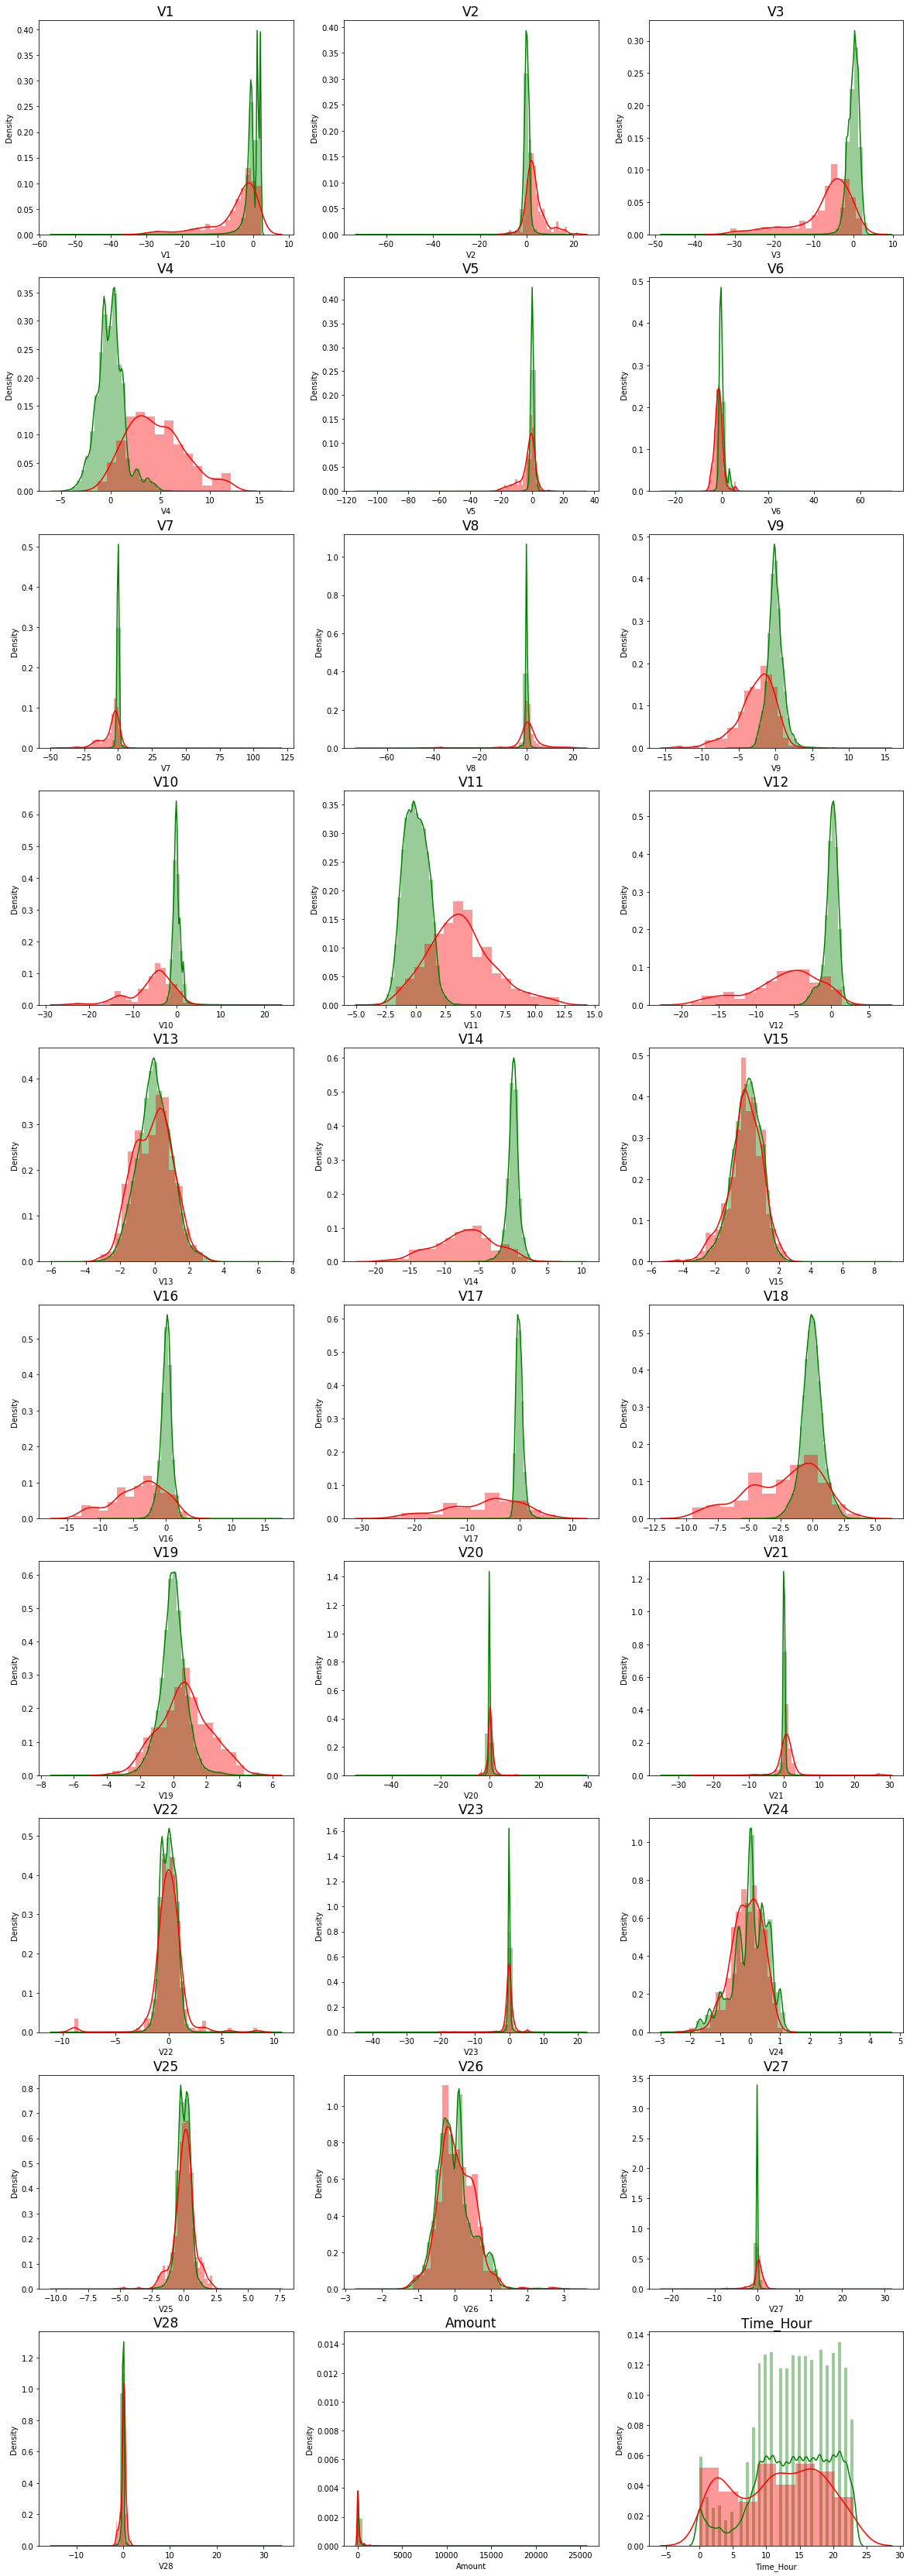

In [14]:
# plot the histogram of a variable from the dataset to see the skewness

normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
  plt.subplot(10,3,n+1)
  sns.distplot(X[col][normal_records], color='green')
  sns.distplot(X[col][fraud_records], color='red')
  plt.title(col, fontsize=17)
plt.show()

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [15]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
pt = PowerTransformer()
pt.fit(X_train)                       ## Fit the PT on training data
X_train_pt = pt.transform(X_train)    ## Then apply on all data
X_test_pt = pt.transform(X_test)

In [16]:
#Create Dataframe
X_train_pt_df = pd.DataFrame(data=X_train_pt,   columns=cols)
X_test_pt_df = pd.DataFrame(data=X_test_pt,   columns=cols)

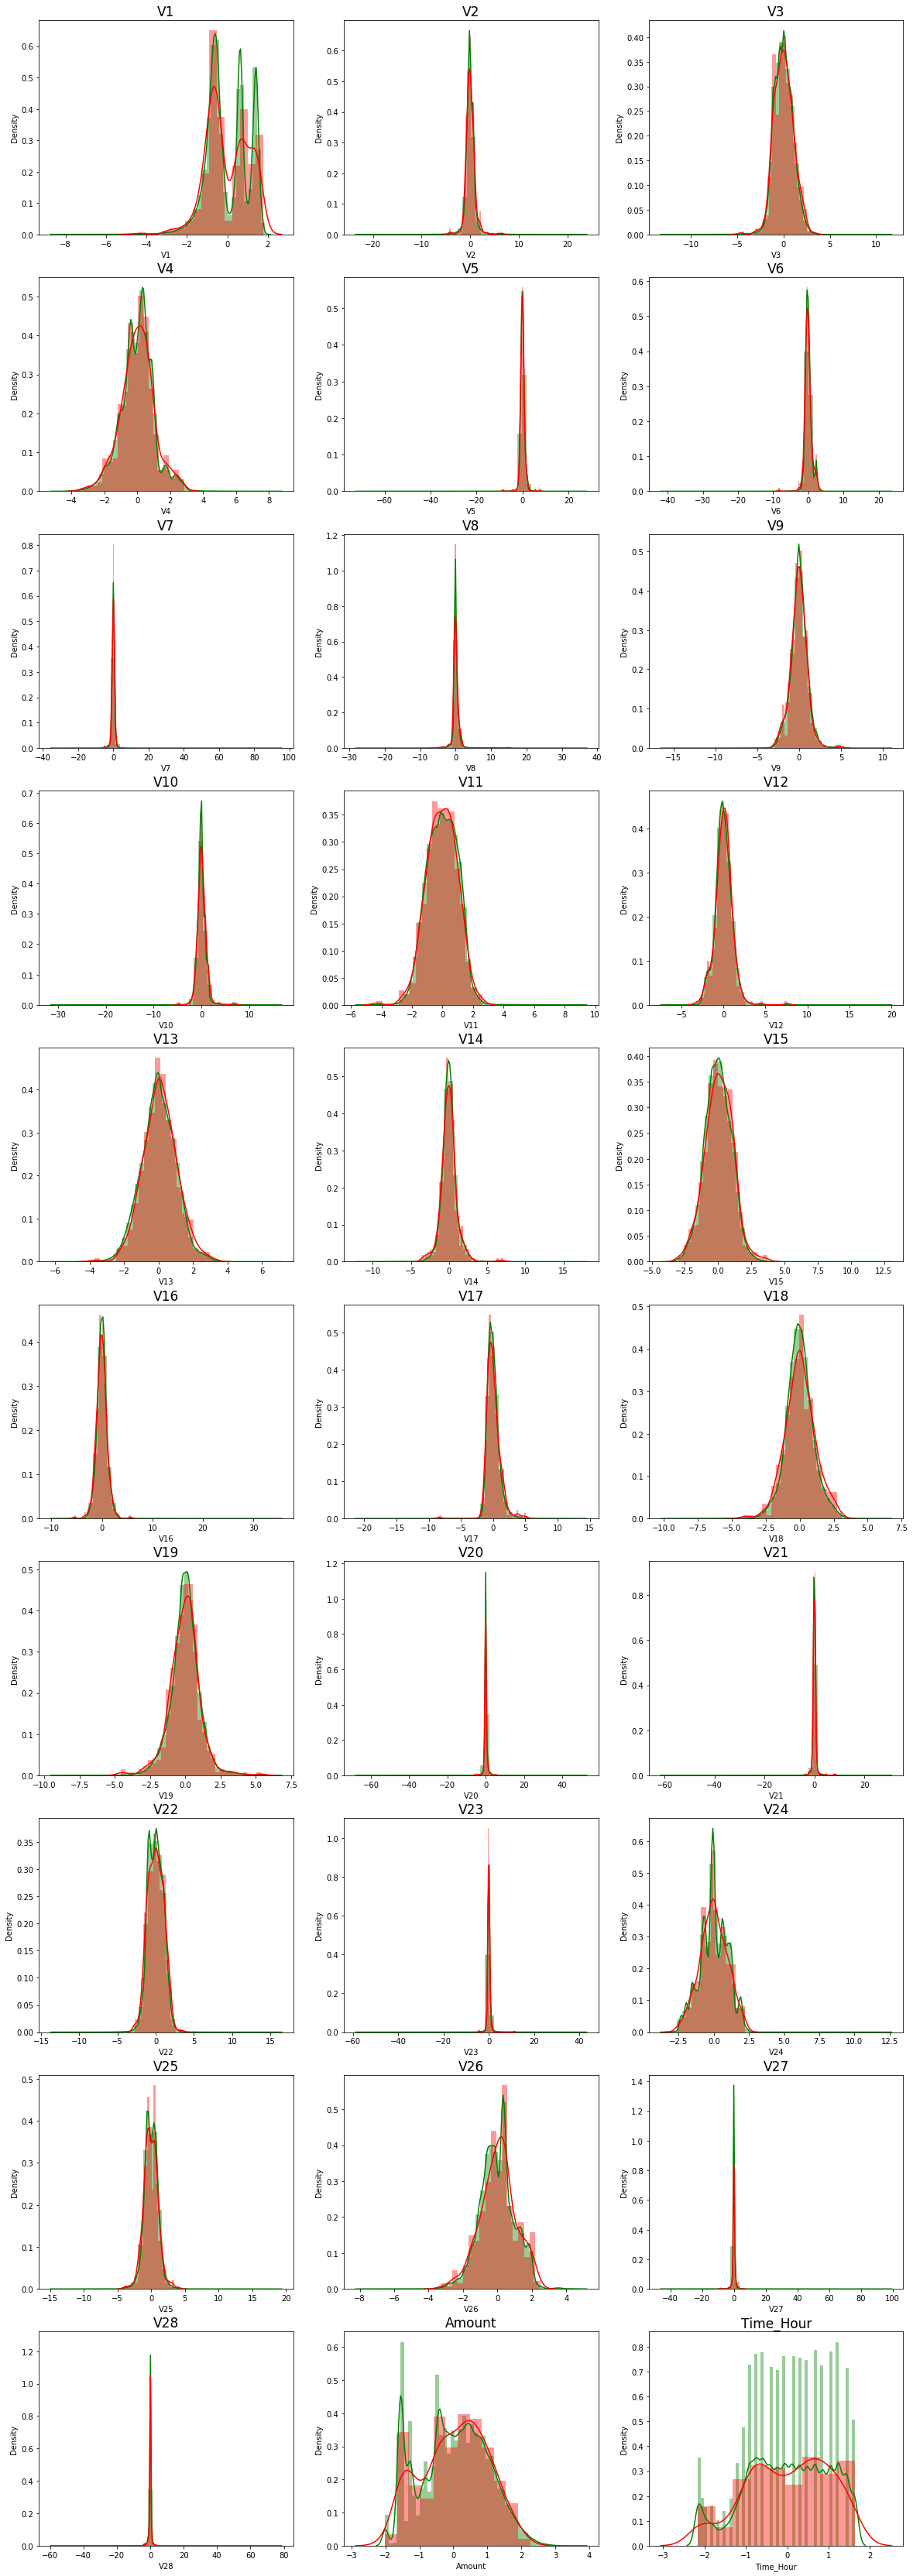

In [17]:
# plot the histogram of a variable from the dataset again to see the result 
plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
  plt.subplot(10,3,n+1)
  sns.distplot(X_train_pt_df[col][normal_records], color='green')
  sns.distplot(X_train_pt_df[col][fraud_records], color='red')
  plt.title(col, fontsize=17)
plt.show()

## Model Building
- Build different models on the imbalanced dataset and see the result

In [18]:
#Create a dataframe to store results
df_Results = pd.DataFrame(columns=['Data_Imbalance_Handiling','Model','Accuracy','roc_value','threshold'])

In [19]:
def Plot_confusion_matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  classNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
  plt.show()

#### Creating functions of different models for re-usability

In [20]:
# Logistic Regression
def buildAndRunLogisticModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):
  
  from sklearn import linear_model #import the package
  from sklearn.model_selection import KFold

  num_C = list(np.power(10.0, np.arange(-10, 10)))
  cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

  searchCV_l2 = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

  searchCV_l1 = linear_model.LogisticRegressionCV(
          Cs=num_C
          ,penalty='l1'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='liblinear'
          ,tol=10
      )
  #searchCV.fit(X_train, y_train)
  searchCV_l2.fit(X_train, y_train)
  searchCV_l1.fit(X_train, y_train)
  print ('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())
  print ('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())

  print("Parameters for l2 regularisations")
  print(searchCV_l2.coef_)
  print(searchCV_l2.intercept_) 
  print(searchCV_l2.scores_) 

  print("Parameters for l1 regularisations")
  print(searchCV_l1.coef_)
  print(searchCV_l1.intercept_) 
  print(searchCV_l1.scores_) 


  #find predicted vallues
  y_pred_l2 = searchCV_l2.predict(X_test)
  y_pred_l1 = searchCV_l1.predict(X_test)
  

  #Find predicted probabilities
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1] 
  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1] 

  # Accuaracy of L2/L1 models
  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l2)
  print("classification Report")
  print(classification_report(y_test, y_pred_l2))
  print("Accuarcy of Logistic model with l1 regularisation : {0}".format(Accuracy_l1))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l1)
  print("classification Report")
  print(classification_report(y_test, y_pred_l1))

  from sklearn.metrics import roc_auc_score
  l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
  print("l2 roc_value: {0}" .format(l2_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l2 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Logistic Regression with L2 Regularisation','Accuracy': Accuracy_l2,'roc_value': l2_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
  print("l1 roc_value: {0}" .format(l1_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l1 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Logistic Regression with L1 Regularisation','Accuracy': Accuracy_l1,'roc_value': l1_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)
  return df_Results

In [21]:

#Evaluate Decision Tree model with 'gini' & 'entropy'
def buildAndRunTreeModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):
  
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.metrics import roc_auc_score
  criteria = ['gini', 'entropy'] 
  scores = {} 
    
  for c in criteria: 
      dt = DecisionTreeClassifier(criterion = c, random_state=42) 
      dt.fit(X_train, y_train) 
      y_pred = dt.predict(X_test)
      test_score = dt.score(X_test, y_test) 
      tree_preds = dt.predict_proba(X_test)[:, 1]
      tree_roc_value = roc_auc_score(y_test, tree_preds)
      scores = test_score 
      print(c + " score: {0}" .format(test_score))
      print("Confusion Matrix")
      Plot_confusion_matrix(y_test, y_pred)
      print("classification Report")
      print(classification_report(y_test, y_pred))
      print(c + " tree_roc_value: {0}" .format(tree_roc_value))
      fpr, tpr, thresholds = metrics.roc_curve(y_test, tree_preds)
      threshold = thresholds[np.argmax(tpr-fpr)]
      print("Tree threshold: {0}".format(threshold))
      roc_auc = metrics.auc(fpr, tpr)
      print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
      plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
      plt.legend(loc=4)
      plt.show()
  
      df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Tree Model with {0} criteria'.format(c),'Accuracy': test_score,'roc_value': tree_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [22]:

 #Evaluate Random Forest model
def buildAndRunRandomForestModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):
 

  from sklearn.ensemble import RandomForestClassifier
  from sklearn.metrics import roc_auc_score

  # Create the model with 100 trees
  RF_model = RandomForestClassifier(n_estimators=100, 
                                bootstrap = True,
                                max_features = 'sqrt', random_state=42)
  # Fit on training data
  RF_model.fit(X_train, y_train)
  RF_test_score = RF_model.score(X_test, y_test)
  RF_model.predict(X_test)

  print('Model Accuracy: {0}'.format(RF_test_score))


  # Actual class predictions
  rf_predictions = RF_model.predict(X_test)

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, rf_predictions)
  print("classification Report")
  print(classification_report(y_test, rf_predictions))

  # Probabilities for each class
  rf_probs = RF_model.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  roc_value = roc_auc_score(y_test, rf_probs)

  print("Random Forest roc_value: {0}" .format(roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("Random Forest threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Random Forest','Accuracy': RF_test_score,'roc_value': roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [23]:

#Evaluate XGboost model
def buildAndRunXGBoostModels(df_Results, DataImabalance,X_train,y_train, X_test, y_test ):
 
  from xgboost import XGBClassifier
  from sklearn.metrics import roc_auc_score
  # fit model no training data
  XGBmodel = XGBClassifier(random_state=42)
  XGBmodel.fit(X_train, y_train)
  y_pred = XGBmodel.predict(X_test)

  XGB_test_score = XGBmodel.score(X_test, y_test)
  print('Model Accuracy: {0}'.format(XGB_test_score))

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred)
  print("classification Report")
  print(classification_report(y_test, y_pred))
  # Probabilities for each class
  XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  XGB_roc_value = roc_auc_score(y_test, XGB_probs)

  print("XGboost roc_value: {0}" .format(XGB_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("XGBoost threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'XGBoost','Accuracy': XGB_test_score,'roc_value': XGB_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.983760023970567
Max auc_roc for l1: 0.985410899045824
Parameters for l2 regularisations
[[-0.09276541 -0.06828297 -0.28652331  0.55493742  0.02789795  0.01396825
  -0.06824953 -0.20408006 -0.18143666 -0.20371291  0.17699968 -0.50183428
  -0.11614819 -0.66830552 -0.0815942  -0.18013738 -0.08164992  0.03866812
  -0.03807332 -0.02310099  0.10465199  0.10090233 -0.03198749 -0.02939204
   0.01001787  0.00785392 -0.04474827 -0.02229527  0.02208228  0.08474082]]
[-8.07230494]
{1: array([[0.90398235, 0.90383704, 0.90383704, 0.90383704, 0.90383704,
        0.90419481, 0.96804377, 0.99255279, 0.99488378, 0.99521346,
        0.99521346, 0.99521346, 0.99521346, 0.99521346, 0.99521346,
        0.99521346, 0.99521346, 0.99521346, 0.99521346, 0.99521346],
       [0.9306611 , 0.9306611 , 0.9306611 , 0.9306611 , 0.9306611 ,
        0.93091836, 0.96502028, 0.98005776, 0.97844439, 0.97856203,
        0.97856203, 0.97856203, 0.9785620

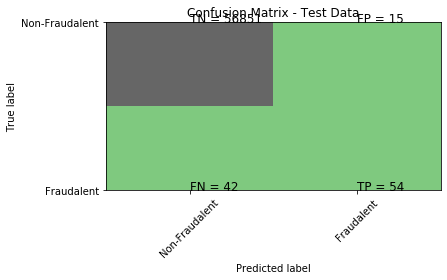

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.78      0.56      0.65        96

    accuracy                           1.00     56962
   macro avg       0.89      0.78      0.83     56962
weighted avg       1.00      1.00      1.00     56962

Accuarcy of Logistic model with l1 regularisation : 0.9988413328183702
Confusion Matrix


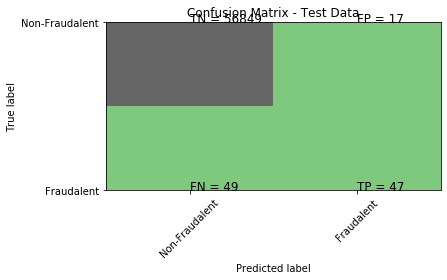

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.73      0.49      0.59        96

    accuracy                           1.00     56962
   macro avg       0.87      0.74      0.79     56962
weighted avg       1.00      1.00      1.00     56962

l2 roc_value: 0.9668061026506759
l2 threshold: 0.0012891785846046598
ROC for the test dataset 96.7%


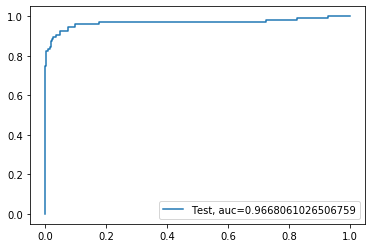

l1 roc_value: 0.9639030791685718
l1 threshold: 0.009276493845029363
ROC for the test dataset 96.4%


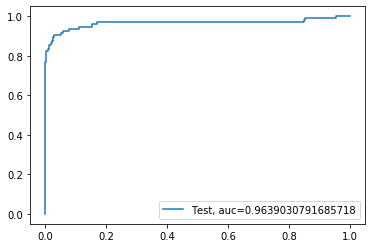

Time Taken by Model: --- 136.8594217300415 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9988062216916541
Confusion Matrix


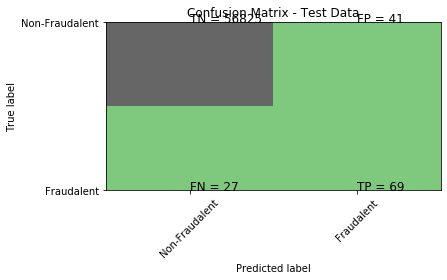

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.63      0.72      0.67        96

    accuracy                           1.00     56962
   macro avg       0.81      0.86      0.83     56962
weighted avg       1.00      1.00      1.00     56962

gini tree_roc_value: 0.8590145033939437
Tree threshold: 1.0
ROC for the test dataset 85.9%


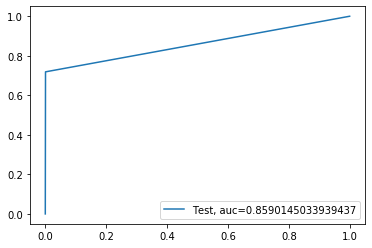

entropy score: 0.9990519995786665
Confusion Matrix


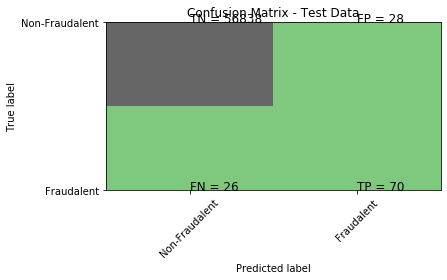

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.71      0.73      0.72        96

    accuracy                           1.00     56962
   macro avg       0.86      0.86      0.86     56962
weighted avg       1.00      1.00      1.00     56962

entropy tree_roc_value: 0.8643371405291973
Tree threshold: 1.0
ROC for the test dataset 86.4%


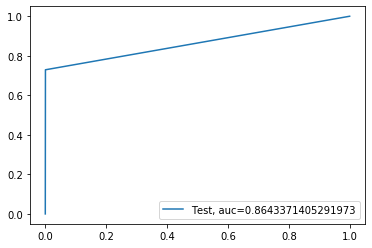

Time Taken by Model: --- 28.57321524620056 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9993504441557529
Confusion Matrix


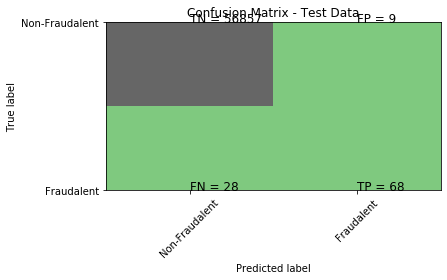

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.88      0.71      0.79        96

    accuracy                           1.00     56962
   macro avg       0.94      0.85      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Random Forest roc_value: 0.940564037972309
Random Forest threshold: 0.01
ROC for the test dataset 94.1%


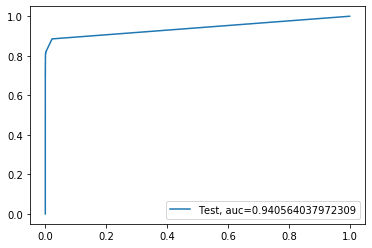

Time Taken by Model: --- 191.41123151779175 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
[21:06:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9994557775359011
Confusion Matrix


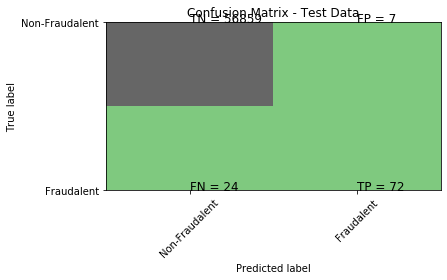

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.91      0.75      0.82        96

    accuracy                           1.00     56962
   macro avg       0.96      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962

XGboost roc_value: 0.9729984744838743
XGBoost threshold: 5.146719195181504e-05
ROC for the test dataset 97.3%


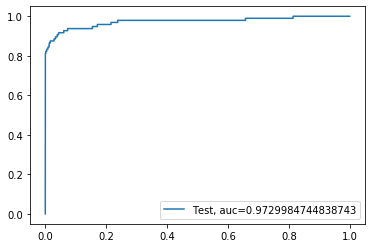

Time Taken by Model: --- 35.439491987228394 seconds ---
--------------------------------------------------------------------------------


In [24]:
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run XGBoost Modela
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )


In [25]:
df_Results.head()

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.998999,0.966806,0.001289
1,Power Transformer,Logistic Regression with L1 Regularisation,0.998841,0.963903,0.009276
2,Power Transformer,Tree Model with gini criteria,0.998806,0.859015,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999052,0.864337,1.000000
4,Power Transformer,Random Forest,0.999350,0.940564,0.010000


#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

In [26]:
#perform cross validation

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters

### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

In [27]:
#perform cross validation
#Lets perfrom StratifiedKFold and check the results
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_SKF_cv, X_test_SKF_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 30473  30496  31002 ... 284804 284805 284806] TEST: [    0     1     2 ... 57017 57018 57019]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 30473  30496  31002 ... 113964 113965 113966]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 81609  82400  83053 ... 170946 170947 170948]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [150654 150660 150661 ... 227866 227867 227868]
TRAIN: [     0      1      2 ... 227866 227867 227868] TEST: [212516 212644 213092 ... 284804 284805 284806]


Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.982345642903909
Max auc_roc for l1: 0.9652106893977332
Parameters for l2 regularisations
[[ 0.00672463  0.06184667 -0.06720321  0.21885108  0.05422155 -0.03203275
  -0.02281633 -0.11497344 -0.0693468  -0.16367677  0.12812486 -0.19237747
  -0.03682021 -0.36066782  0.00341604 -0.0879026  -0.07263692 -0.00067565
   0.00388495 -0.02828183  0.0380999   0.02338494 -0.01156945 -0.0099861
  -0.0065303   0.00631414 -0.01008767 -0.0016671   0.00040065  0.00086308]]
[-7.43649513]
{1: array([[0.69244071, 0.69420377, 0.71447445, 0.83769026, 0.95579724,
        0.97136042, 0.98915673, 0.99473675, 0.99129855, 0.99109226,
        0.99109226, 0.99109226, 0.99109226, 0.99109226, 0.99109226,
        0.99109226, 0.99109226, 0.99109226, 0.99109226, 0.99109226],
       [0.60702115, 0.60867551, 0.6291689 , 0.76886476, 0.90900788,
        0.94879693, 0.96040933, 0.98126391, 0.98548404, 0.98177014,
        0.98177014, 0.98177014, 0.9817701

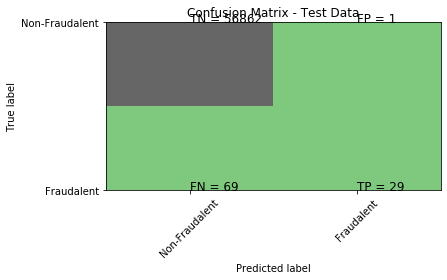

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.98      0.65      0.73     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9987535331191517
Confusion Matrix


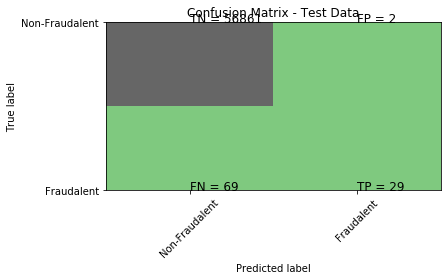

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.97      0.65      0.72     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9833138151238547
l2 threshold: 0.001574989231012254
ROC for the test dataset 98.3%


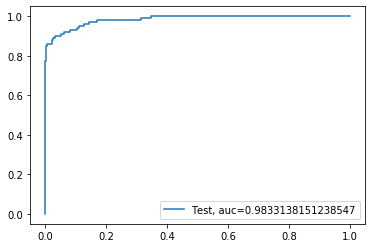

l1 roc_value: 0.8890758561483437
l1 threshold: 0.021087492766200023
ROC for the test dataset 88.9%


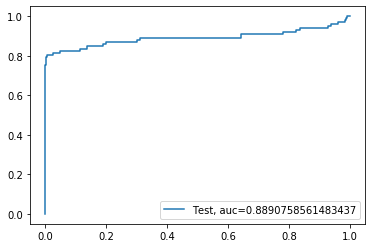

Time Taken by Model: --- 298.9155478477478 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.998841312476958
Confusion Matrix


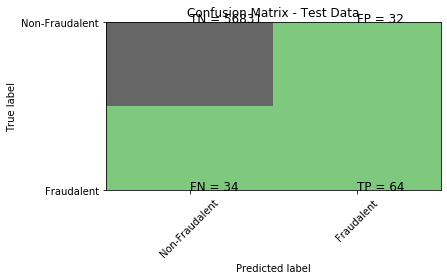

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.67      0.65      0.66        98

    accuracy                           1.00     56961
   macro avg       0.83      0.83      0.83     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8262492341959029
Tree threshold: 1.0
ROC for the test dataset 82.6%


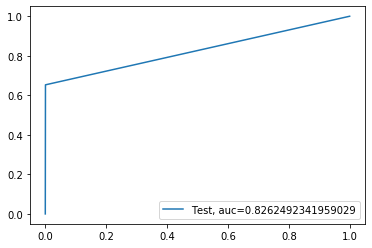

entropy score: 0.9990168711925703
Confusion Matrix


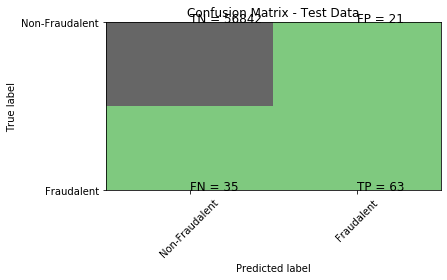

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.75      0.64      0.69        98

    accuracy                           1.00     56961
   macro avg       0.87      0.82      0.85     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8212439170839185
Tree threshold: 1.0
ROC for the test dataset 82.1%


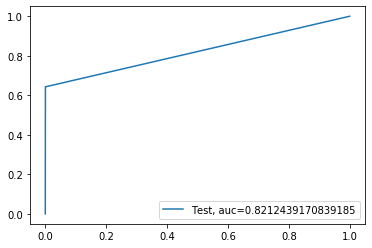

Time Taken by Model: --- 29.657018423080444 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


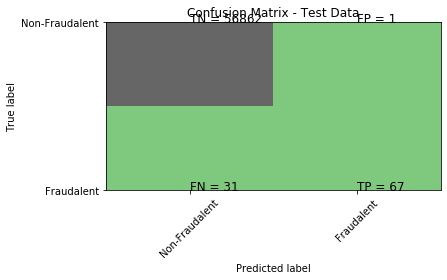

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.68      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.84      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9464721329855826
Random Forest threshold: 0.01
ROC for the test dataset 94.6%


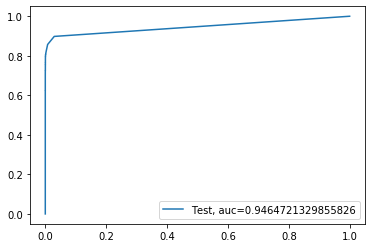

Time Taken by Model: --- 177.78639936447144 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
[21:15:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9994382121100402
Confusion Matrix


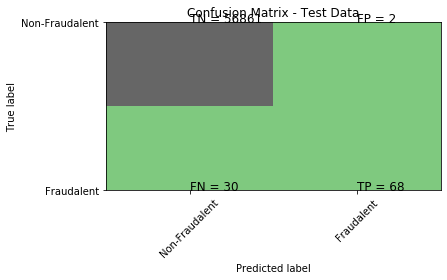

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.69      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.85      0.90     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9728122049164354
XGBoost threshold: 0.00010038168693426996
ROC for the test dataset 97.3%


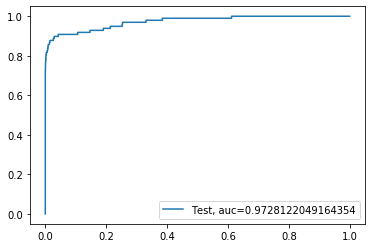

Time Taken by Model: --- 35.50887060165405 seconds ---
--------------------------------------------------------------------------------


In [28]:
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results,"StratifiedKFold Cross Validation", X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run XGBoost Modela
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )


In [29]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.998999,0.966806,0.001289
1,Power Transformer,Logistic Regression with L1 Regularisation,0.998841,0.963903,0.009276
2,Power Transformer,Tree Model with gini criteria,0.998806,0.859015,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999052,0.864337,1.000000
4,Power Transformer,Random Forest,0.999350,0.940564,0.010000
5,Power Transformer,XGBoost,0.999456,0.972998,0.000051
6,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983314,0.001575
7,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087
8,StratifiedKFold Cross Validation,Tree Model with gini criteria,0.998841,0.826249,1.000000
9,StratifiedKFold Cross Validation,Tree Model with entropy criteria,0.999017,0.821244,1.000000


#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [30]:
# Logistic Regression
from sklearn import linear_model #import the package
from sklearn.model_selection import KFold

num_C = list(np.power(10.0, np.arange(-10, 10)))
cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

clf = linear_model.LogisticRegressionCV( #initialise the model with optimum hyperparameters
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )


clf.fit(X_train, y_train)

#print the evaluation score on the X_test by choosing the best evaluation metric
print ('Max auc_roc for l2:', clf.scores_[1].mean(axis=0).max())


print("Parameters for l2 regularisations")
print(clf.coef_)
print(clf.intercept_) 
print(clf.scores_) 


#find predicted vallues
y_pred_l2 = clf.predict(X_test)


#Find predicted probabilities
y_pred_probs_l2 = clf.predict_proba(X_test)[:,1] 


# Accuaracy of L2/L1 models
Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)


print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))


from sklearn.metrics import roc_auc_score
l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
print("l2 roc_value: {0}" .format(l2_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
threshold = thresholds[np.argmax(tpr-fpr)]
print("l2 threshold: {0}".format(threshold))

Max auc_roc for l2: 0.9862993477240949
Parameters for l2 regularisations
[[ 2.05746922e-02  3.26205786e-02 -8.95985757e-02  2.38181714e-01
   8.28337334e-02 -4.89717810e-02 -3.30074718e-02 -1.08629372e-01
  -9.28053677e-02 -1.75797569e-01  1.35311508e-01 -2.07714209e-01
  -4.36524351e-02 -3.79031009e-01 -1.10386120e-02 -1.04744932e-01
  -1.14640498e-01 -8.49274841e-03  1.50254374e-02 -5.85165349e-03
   3.98194338e-02  2.46357514e-02  1.92950286e-03 -1.57912044e-02
  -7.89934582e-03  5.19570255e-03 -3.26955807e-03 -2.42493907e-04
   3.00378816e-04  3.61422079e-03]]
[-7.48531725]
{1: array([[0.58216967, 0.58434192, 0.61022463, 0.77826132, 0.94270322,
        0.98595298, 0.9960218 , 0.99464812, 0.9938935 , 0.99487523,
        0.99388862, 0.99388862, 0.99388862, 0.99388862, 0.99388862,
        0.99388862, 0.99388862, 0.99388862, 0.99388862, 0.99388862],
       [0.56189515, 0.56177104, 0.57985686, 0.72102454, 0.88967518,
        0.93984492, 0.96785145, 0.97891366, 0.97819876, 0.98078817,
  

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

### Random Oversampling

In [31]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler


skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    ROS = RandomOverSampler(sampling_strategy=0.5)
    X_over, y_over= ROS.fit_resample(X_train, y_train)
  
#Create Dataframe for X_over
X_over = pd.DataFrame(data=X_over,   columns=cols)

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9865804501139893
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[ 0.36475192  0.39046804  0.27495954  0.84697895  0.34208461 -0.48948965
  -0.33481008 -0.33793933 -0.19753481 -0.65320682  0.29230983 -0.90342563
  -0.31312358 -0.89226249  0.02426688 -0.52574773 -0.29761169 -0.1208005
   0.11821837 -0.69277389  0.06990664  0.52196278  0.12371106 -0.41972732
   0.21402626 -0.08707646 -0.30780596  0.20346806  0.00545108  0.04269861]]
[-5.17478946]
{1: array([[0.62932032, 0.75709073, 0.90320331, 0.95354731, 0.97592802,
        0.98415722, 0.9857016 , 0.98593061, 0.98607615, 0.9861389 ,
        0.9861389 , 0.9861448 , 0.9861448 , 0.9861448 , 0.9861448 ,
        0.9861448 , 0.9861448 , 0.9861448 , 0.9861448 , 0.9861448 ],
       [0.63088056, 0.75763322, 0.90557629, 0.95611746, 0.97678079,
        0.98430908, 0.9856964 , 0.98611042, 0.98640949, 0.98650153,
        0.98651382, 0.98651382, 0.98651382, 0.98651382,

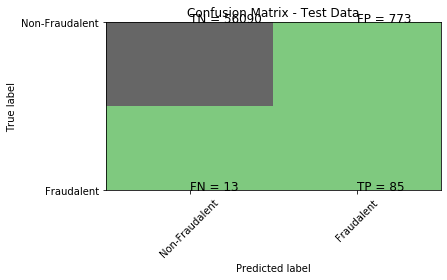

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.10      0.87      0.18        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.59     56961
weighted avg       1.00      0.99      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


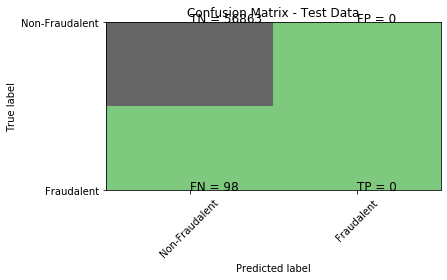

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9805942460342383
l2 threshold: 0.426260906166447
ROC for the test dataset 98.1%


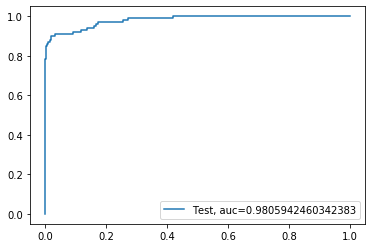

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


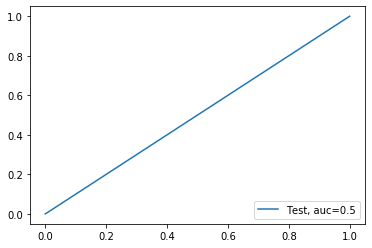

Time Taken by Model: --- 343.2705852985382 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9989642035778866
Confusion Matrix


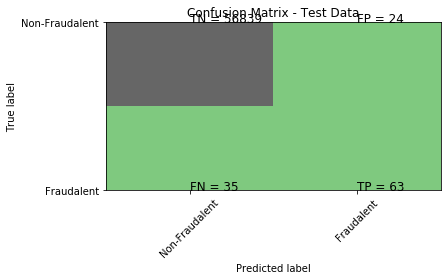

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.72      0.64      0.68        98

    accuracy                           1.00     56961
   macro avg       0.86      0.82      0.84     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8212175378918252
Tree threshold: 1.0
ROC for the test dataset 82.1%


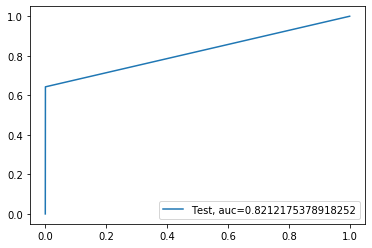

entropy score: 0.9992450975228665
Confusion Matrix


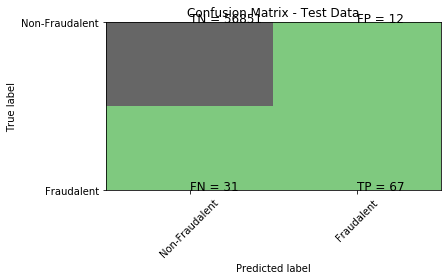

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.85      0.68      0.76        98

    accuracy                           1.00     56961
   macro avg       0.92      0.84      0.88     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8417312179255044
Tree threshold: 1.0
ROC for the test dataset 84.2%


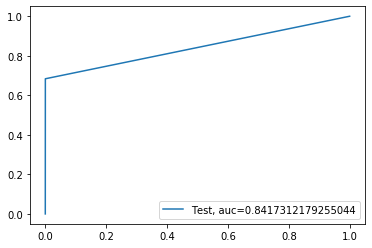

Time Taken by Model: --- 18.820265293121338 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995084355962852
Confusion Matrix


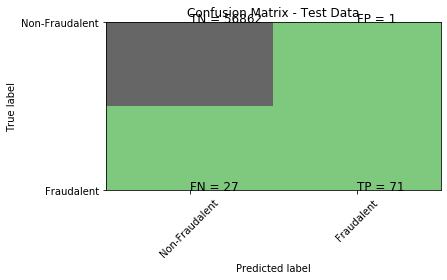

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.72      0.84        98

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9356069564980204
Random Forest threshold: 0.02
ROC for the test dataset 93.6%


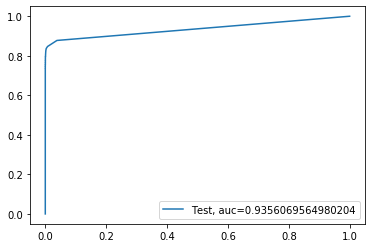

Time Taken by Model: --- 137.53367018699646 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
[21:27:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9994733238531627
Confusion Matrix


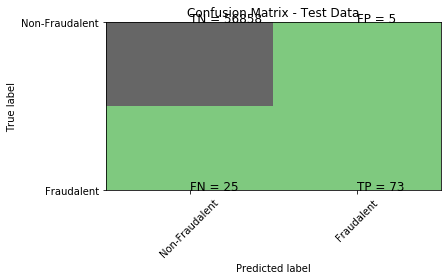

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.74      0.83        98

    accuracy                           1.00     56961
   macro avg       0.97      0.87      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9851709461372787
XGBoost threshold: 6.0486792790470645e-05
ROC for the test dataset 98.5%


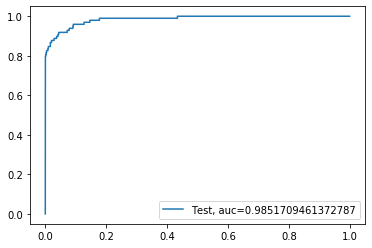

Time Taken by Model: --- 46.120861530303955 seconds ---
--------------------------------------------------------------------------------


In [32]:
Data_Imbalance_Handiling	 = "Random Oversampling with StratifiedKFold CV "
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results , Data_Imbalance_Handiling , X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )


In [33]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.998999,0.966806,0.001289
1,Power Transformer,Logistic Regression with L1 Regularisation,0.998841,0.963903,0.009276
2,Power Transformer,Tree Model with gini criteria,0.998806,0.859015,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999052,0.864337,1.000000
4,Power Transformer,Random Forest,0.999350,0.940564,0.010000
5,Power Transformer,XGBoost,0.999456,0.972998,0.000051
6,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983314,0.001575
7,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087
8,StratifiedKFold Cross Validation,Tree Model with gini criteria,0.998841,0.826249,1.000000
9,StratifiedKFold Cross Validation,Tree Model with entropy criteria,0.999017,0.821244,1.000000


### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

### Print the class distribution after applying SMOTE 

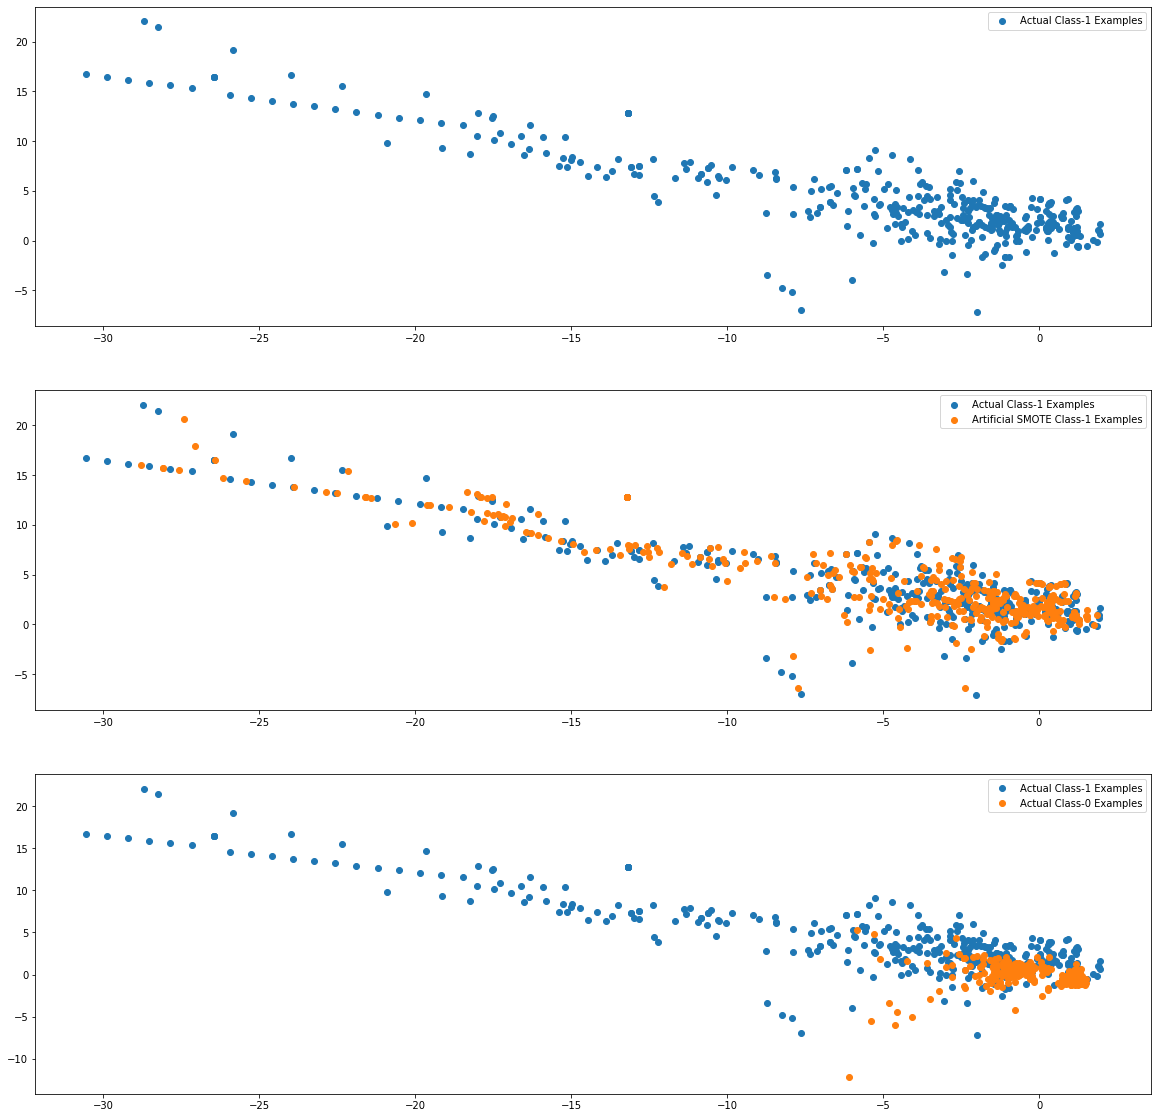

In [34]:
from imblearn import over_sampling
SMOTE = over_sampling.SMOTE(random_state=0)

X_train_Smote, y_train_Smote= SMOTE.fit_resample(X_train.to_numpy(), y_train) 

#Create dataframe
#X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_Smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()


#Create dataframe
X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)

In [35]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    SMOTE = over_sampling.SMOTE(random_state=0)
    X_train_Smote, y_train_Smote= SMOTE.fit_resample(X_train, y_train)
  
#Create Dataframe for X_over
X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)


Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9930151102630809
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[ 0.77295757  0.70990421  0.68902821  0.93855483  0.49724146 -0.93775359
  -0.69715883 -0.50698416 -0.42307775 -0.9203155   0.61747023 -1.25029138
  -0.23831484 -1.52850075  0.12543275 -0.78244993 -0.84419144 -0.43412921
   0.22164307 -1.0838067  -0.02377885  0.56559503  0.40536936 -0.91706871
   0.50649814  0.03393942 -0.1820728   0.84938997  0.00904192  0.0110326 ]]
[-5.30146186]
{1: array([[0.64927751, 0.78559745, 0.91748425, 0.96520455, 0.98466299,
        0.98956394, 0.99070011, 0.99160716, 0.99195991, 0.99205746,
        0.99206947, 0.99206947, 0.99206947, 0.99206947, 0.99206947,
        0.99206947, 0.99206947, 0.99206947, 0.99206947, 0.99206947],
       [0.6460276 , 0.7845671 , 0.91904908, 0.96766046, 0.98636753,
        0.99079354, 0.99182711, 0.99273088, 0.99311463, 0.9932076 ,
        0.99322267, 0.99322267, 0.99322267, 0.99322267

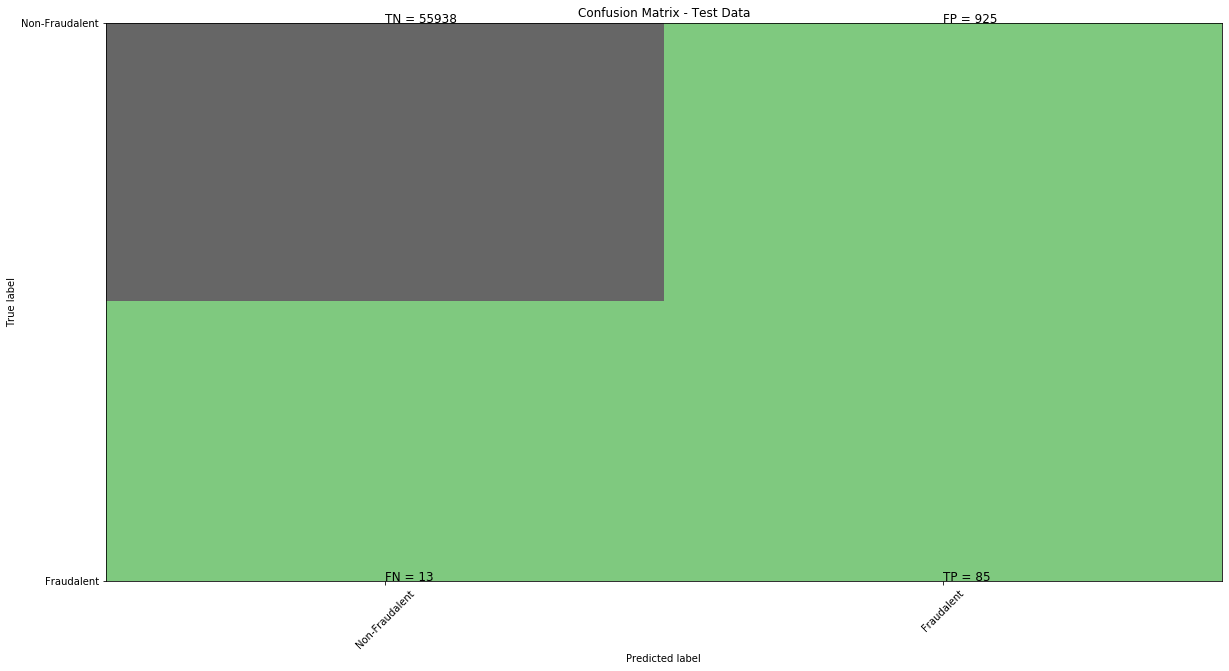

classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.08      0.87      0.15        98

    accuracy                           0.98     56961
   macro avg       0.54      0.93      0.57     56961
weighted avg       1.00      0.98      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


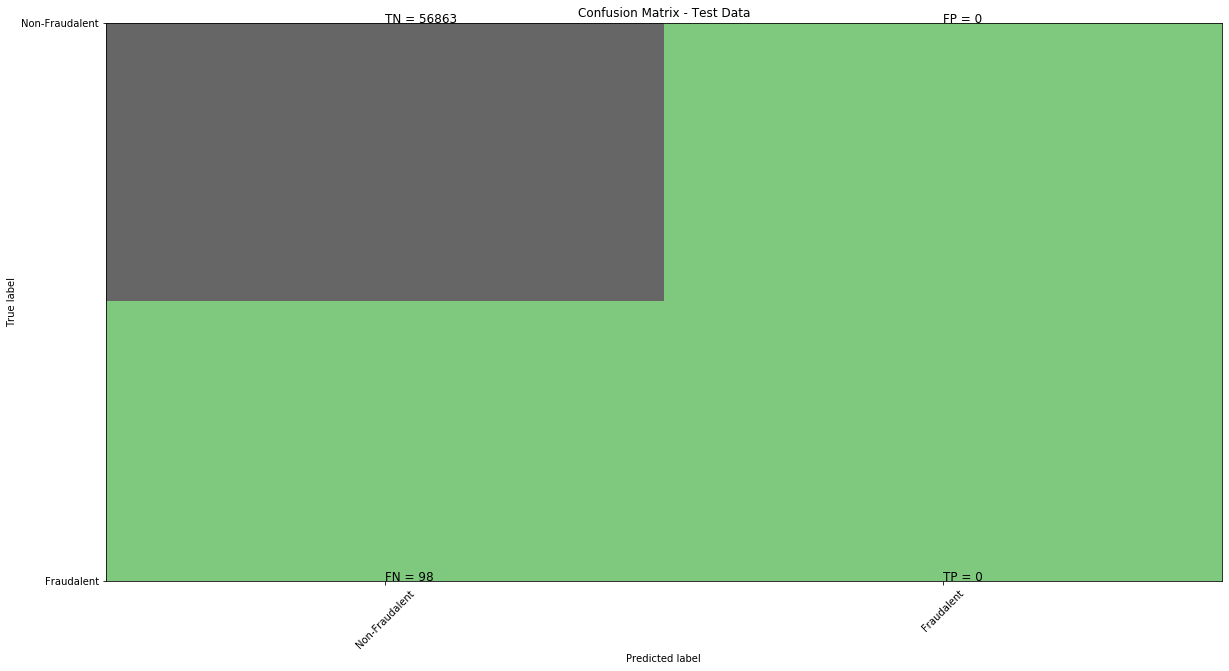

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.974585801821564
l2 threshold: 0.39391725732817195
ROC for the test dataset 97.5%


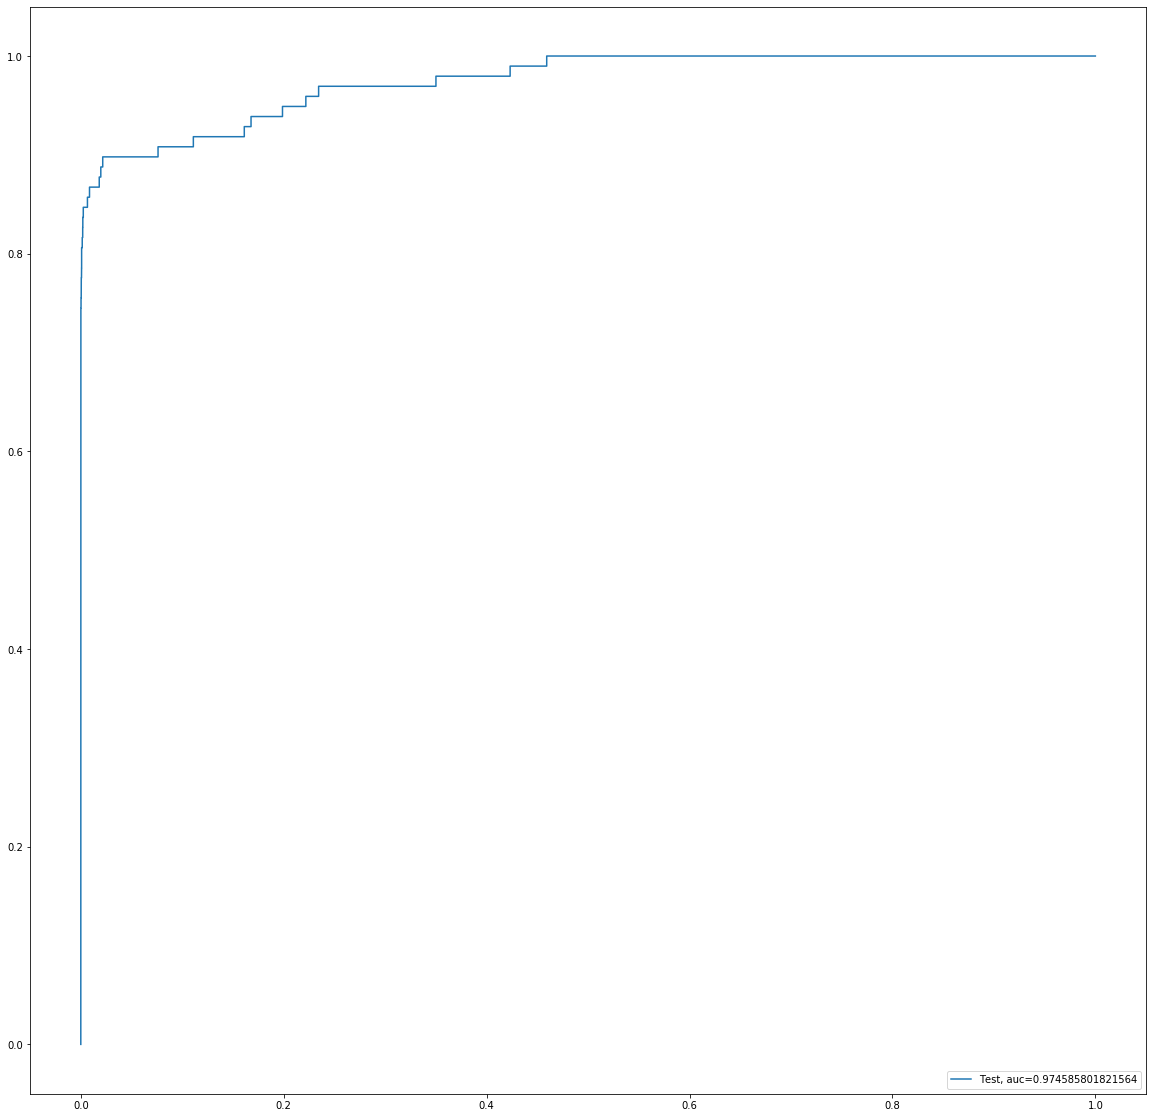

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


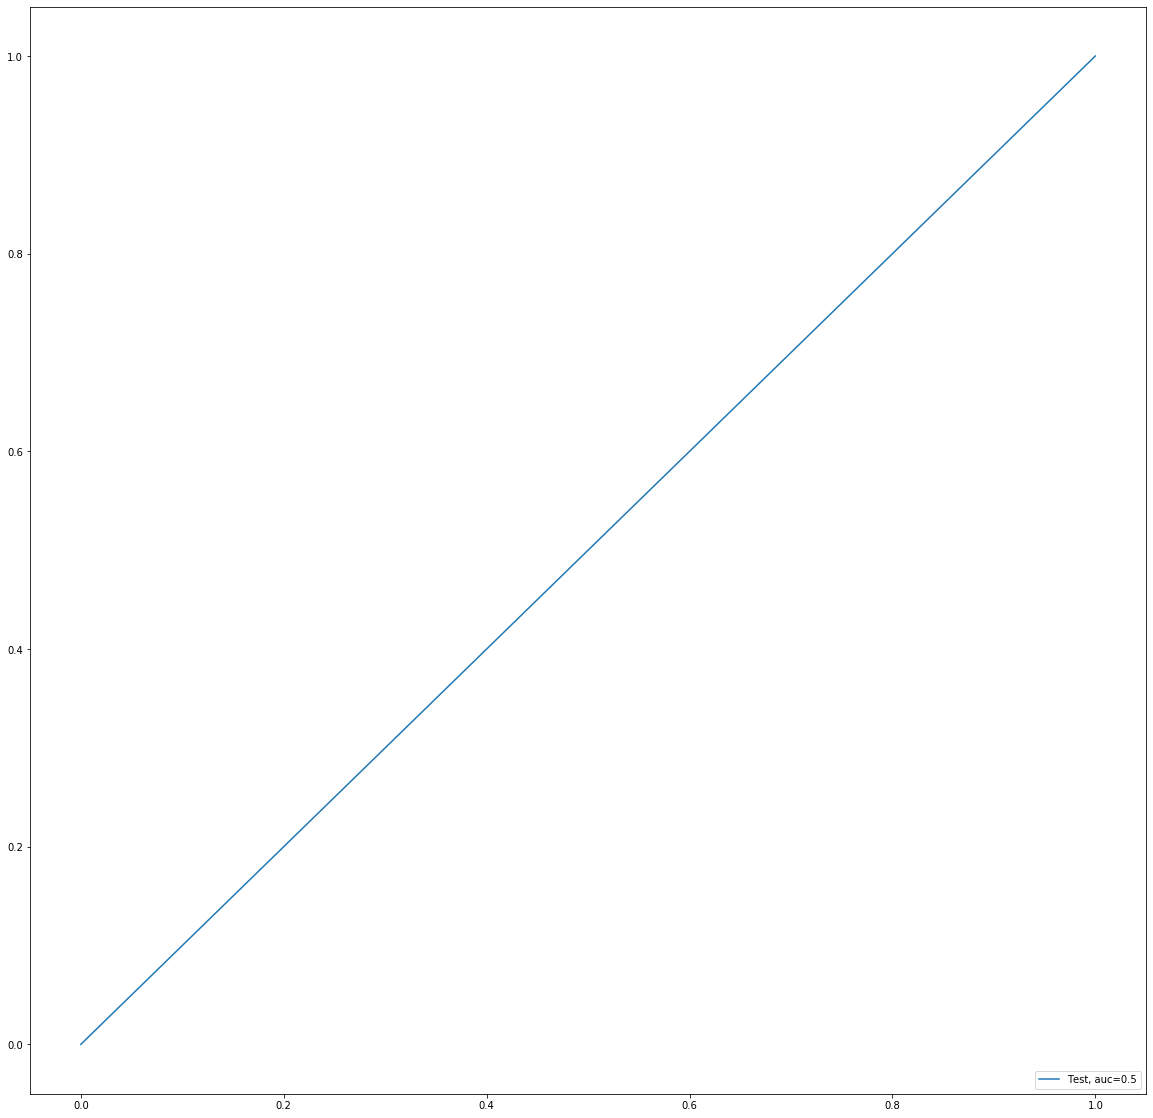

Time Taken by Model: --- 445.28032326698303 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9977528484401608
Confusion Matrix


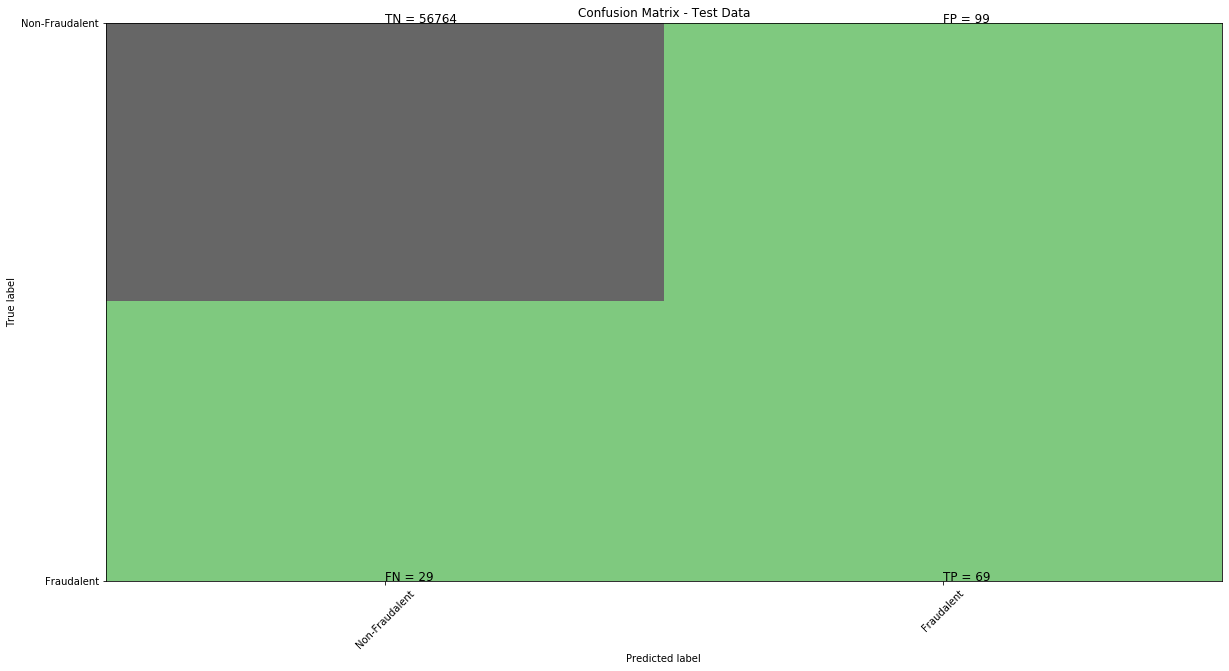

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.41      0.70      0.52        98

    accuracy                           1.00     56961
   macro avg       0.71      0.85      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8511703029874526
Tree threshold: 1.0
ROC for the test dataset 85.1%


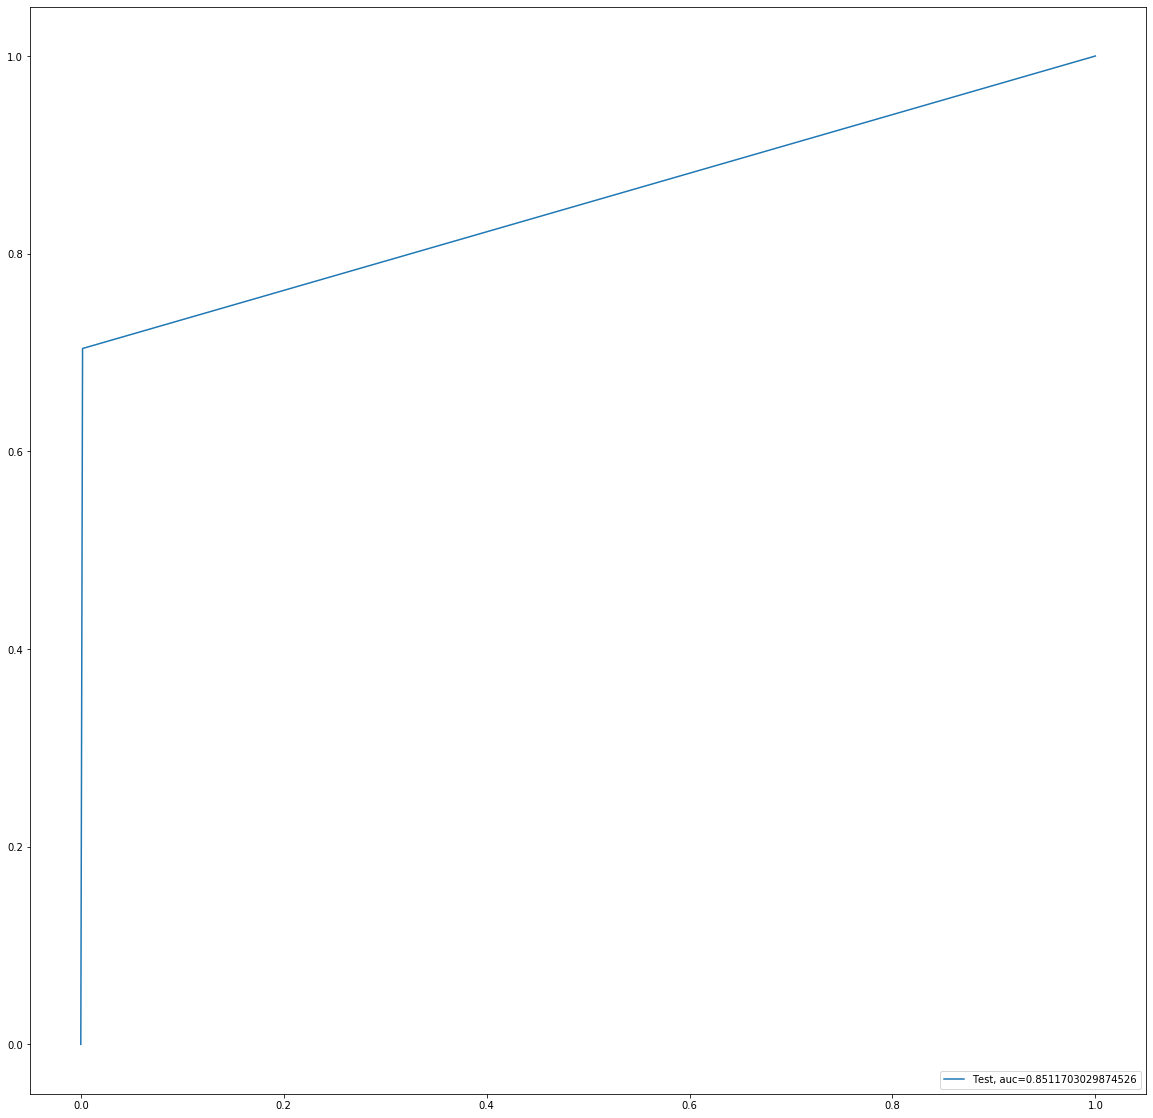

entropy score: 0.9969803900914661
Confusion Matrix


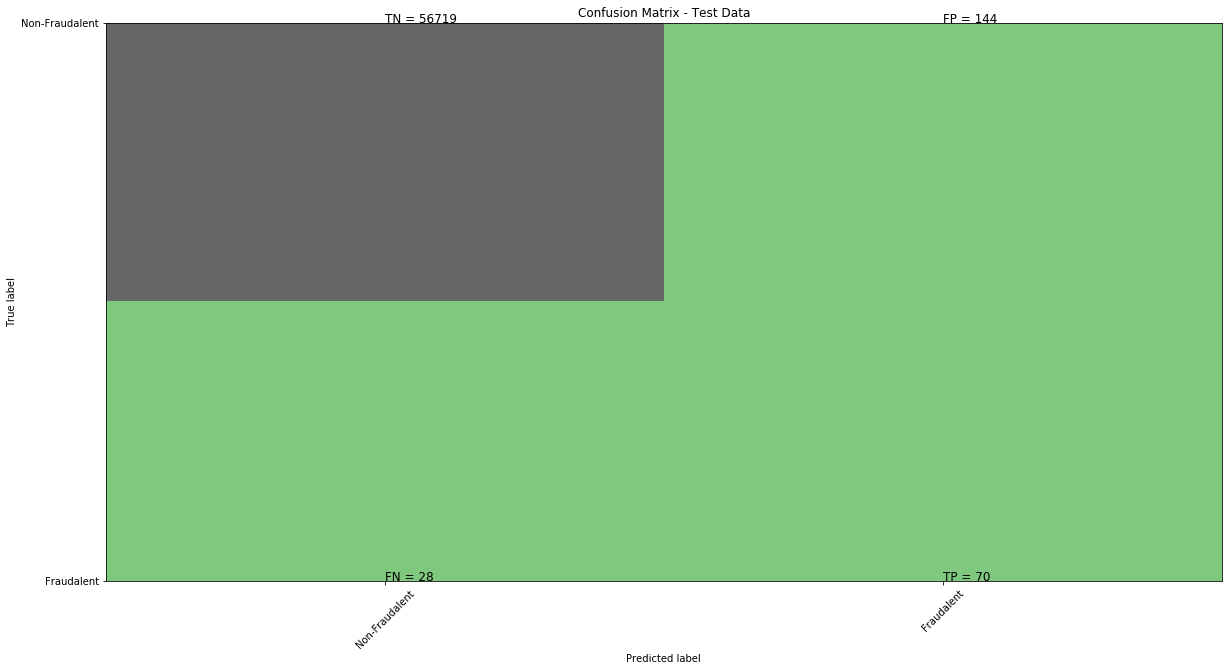

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.33      0.71      0.45        98

    accuracy                           1.00     56961
   macro avg       0.66      0.86      0.72     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8558766559223799
Tree threshold: 1.0
ROC for the test dataset 85.6%


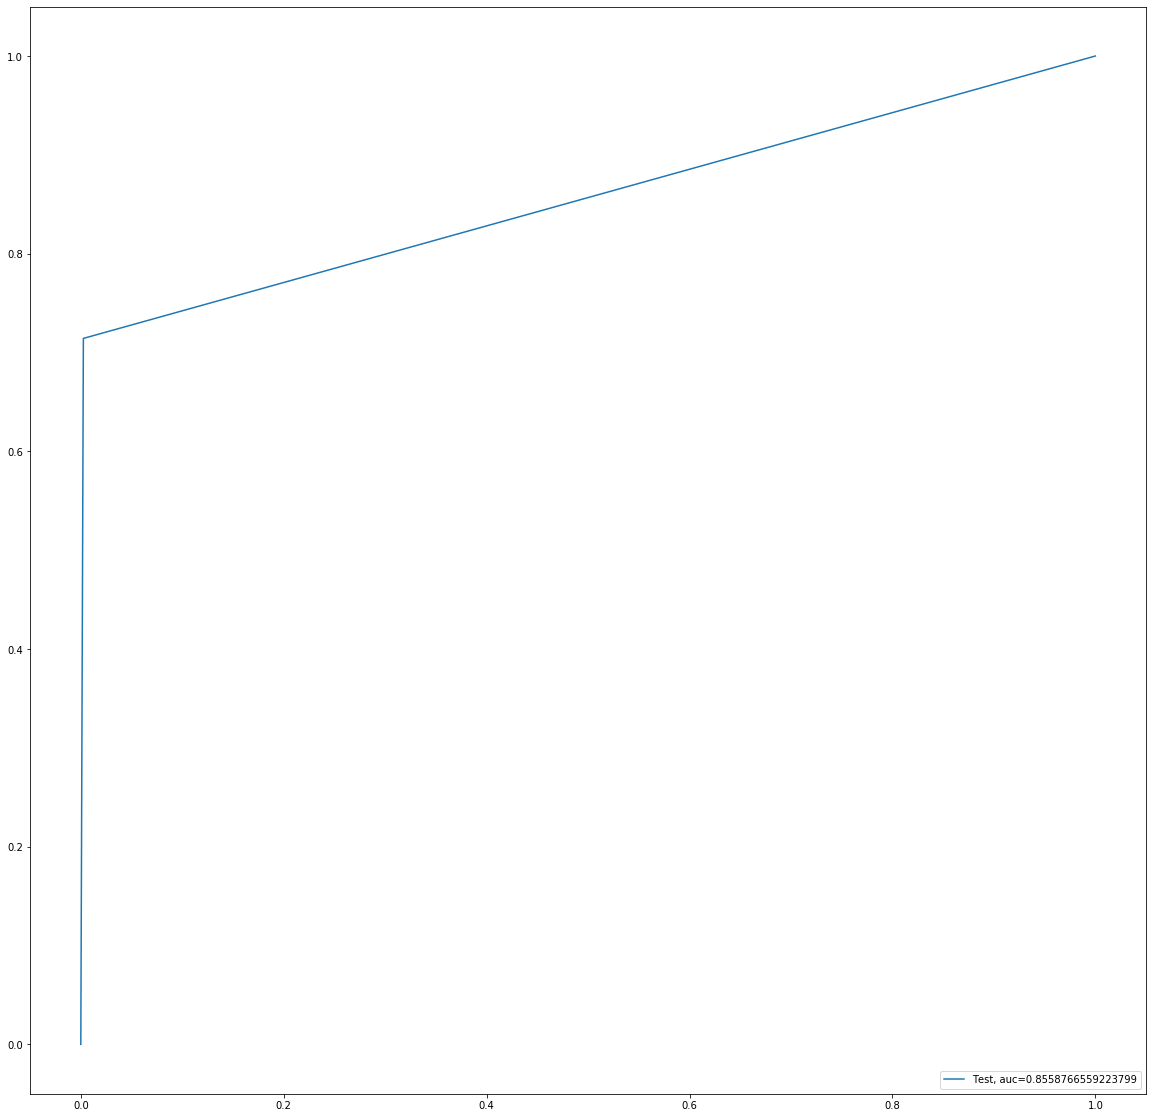

Time Taken by Model: --- 67.92243933677673 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


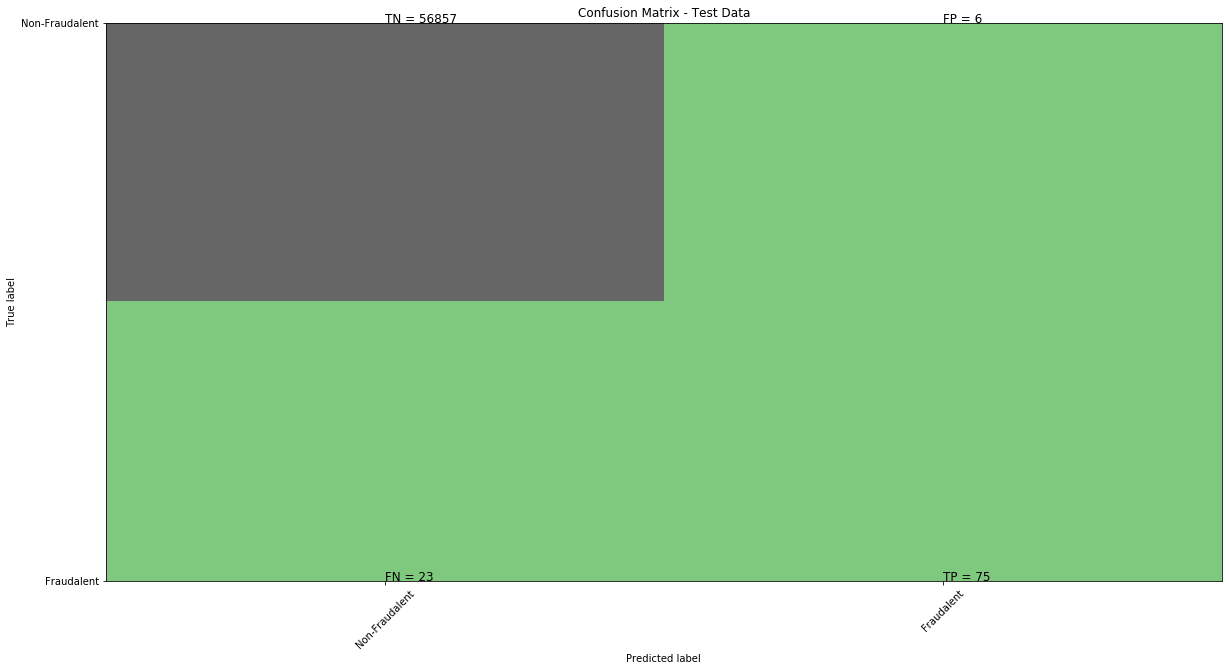

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9614705879186172
Random Forest threshold: 0.05
ROC for the test dataset 96.1%


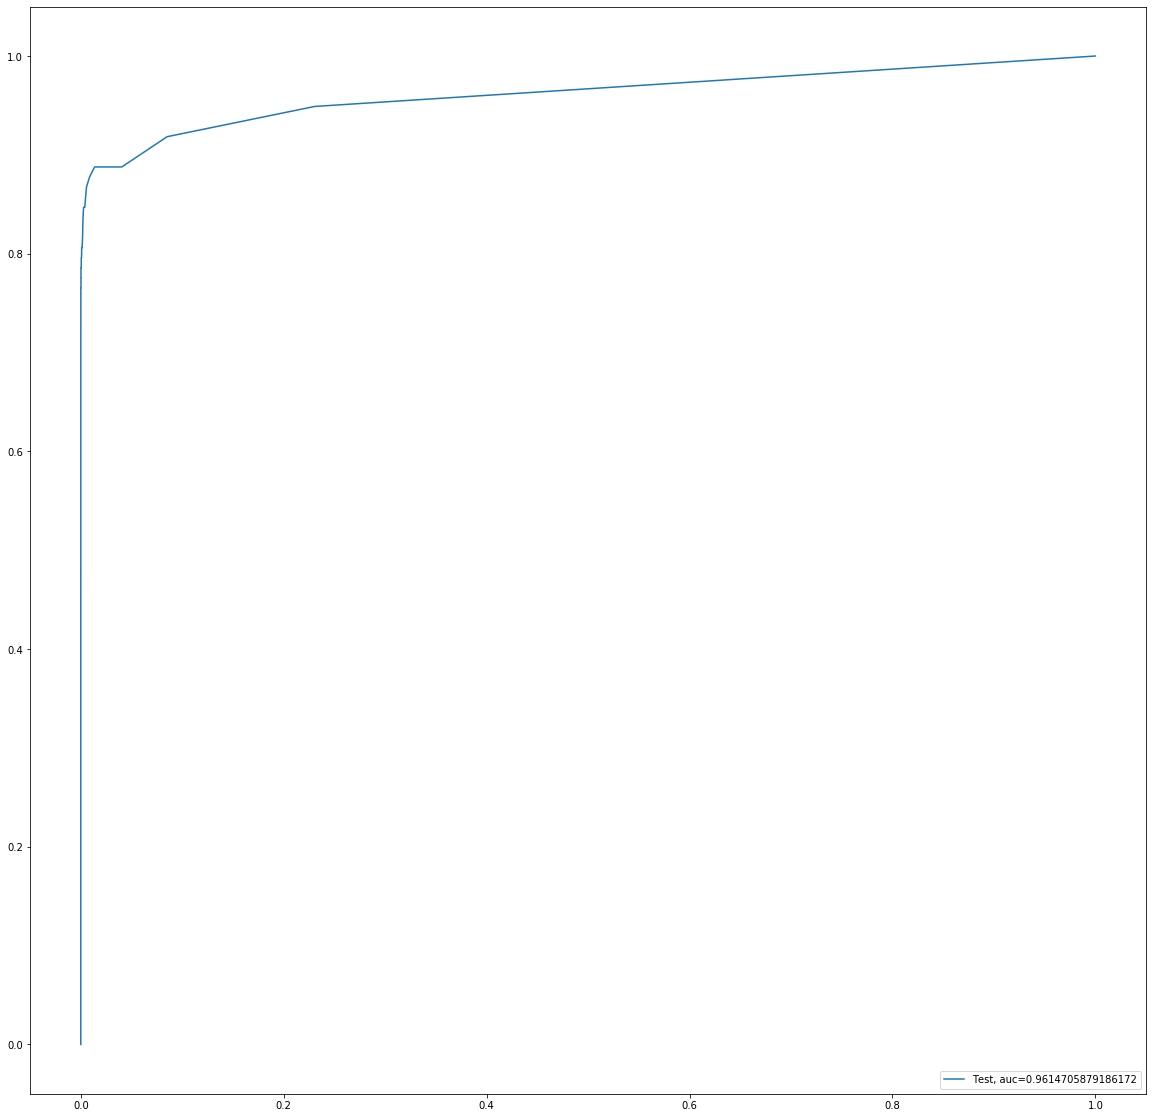

Time Taken by Model: --- 318.56640219688416 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
[21:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9994382121100402
Confusion Matrix


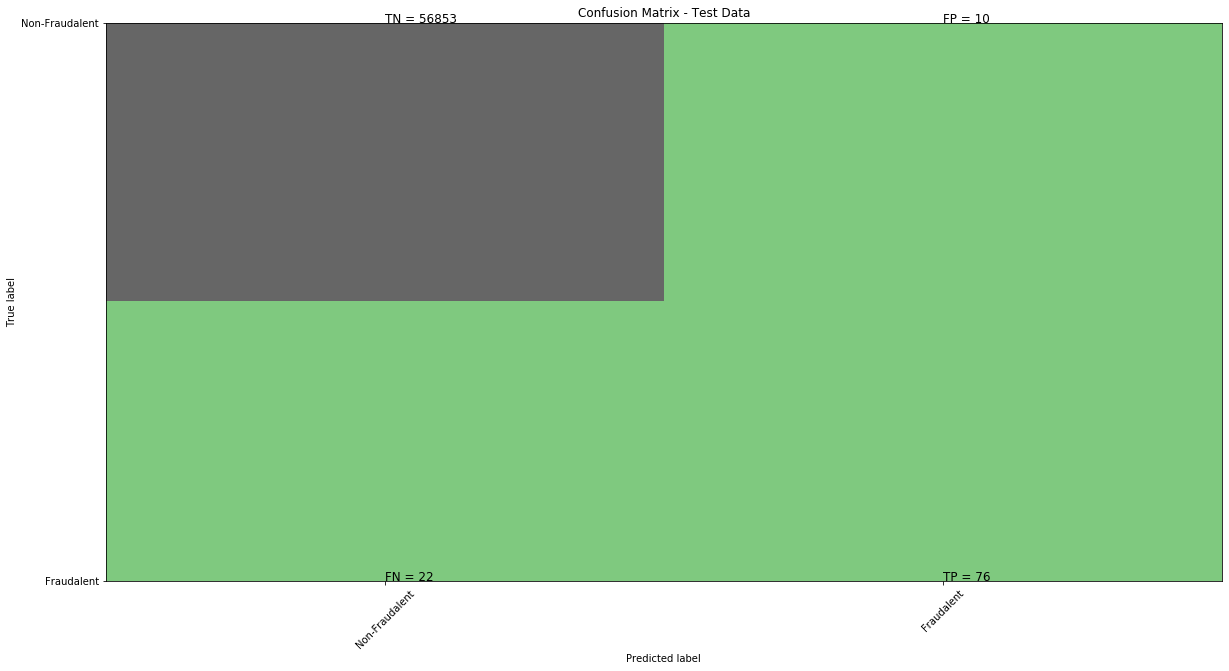

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.78      0.83        98

    accuracy                           1.00     56961
   macro avg       0.94      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9741530574560336
XGBoost threshold: 0.00022058551257941872
ROC for the test dataset 97.4%


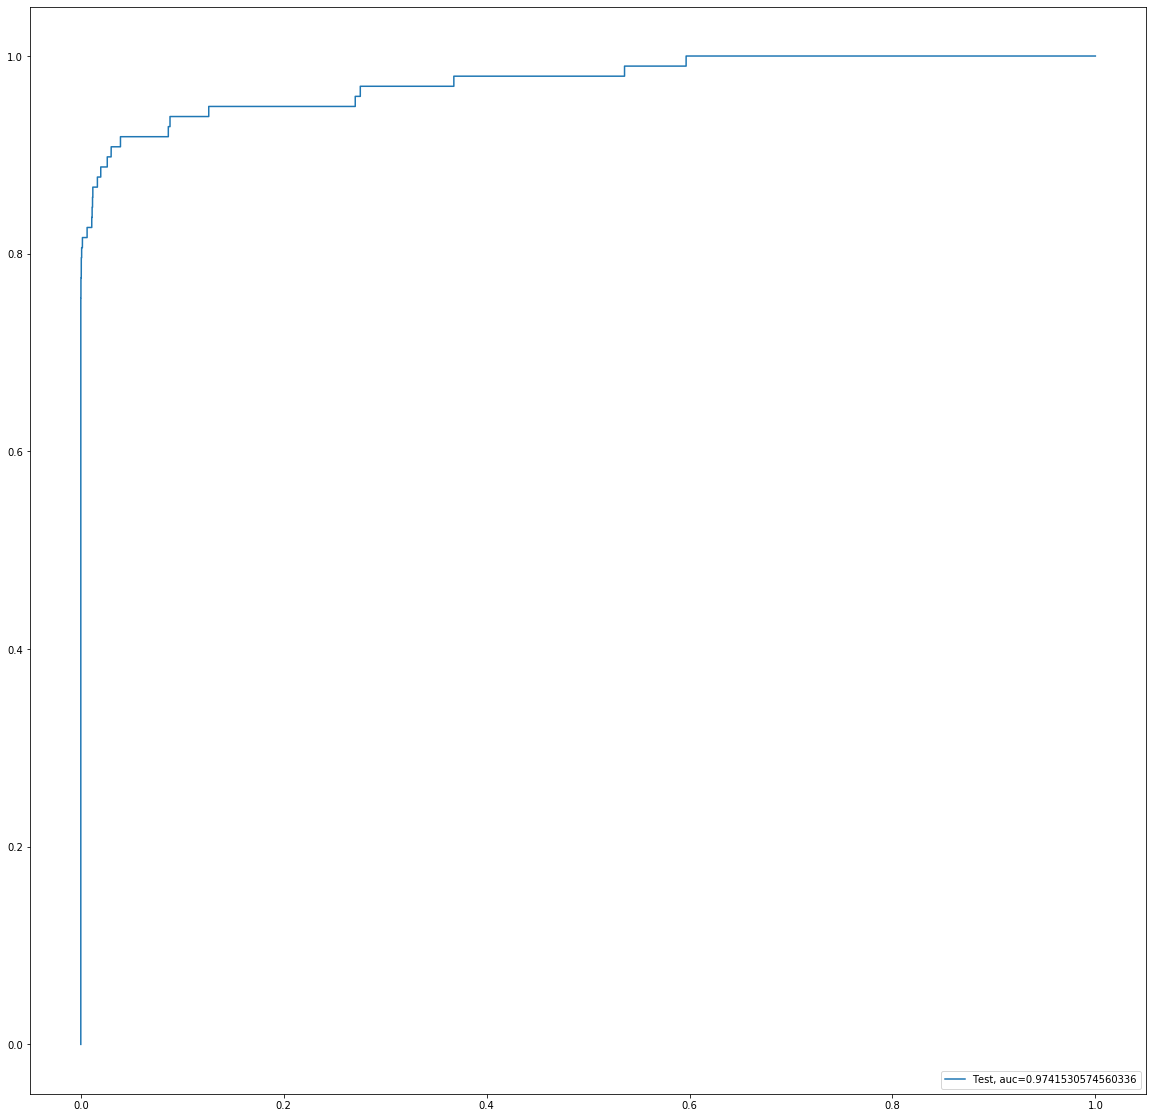

Time Taken by Model: --- 93.45668768882751 seconds ---
--------------------------------------------------------------------------------


In [36]:
Data_Imbalance_Handiling	 = "SMOTE Oversampling with StratifiedKFold CV "
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )


##### Build models on other algorithms to see the better performing on SMOTE

### Print the class distribution after applying ADASYN

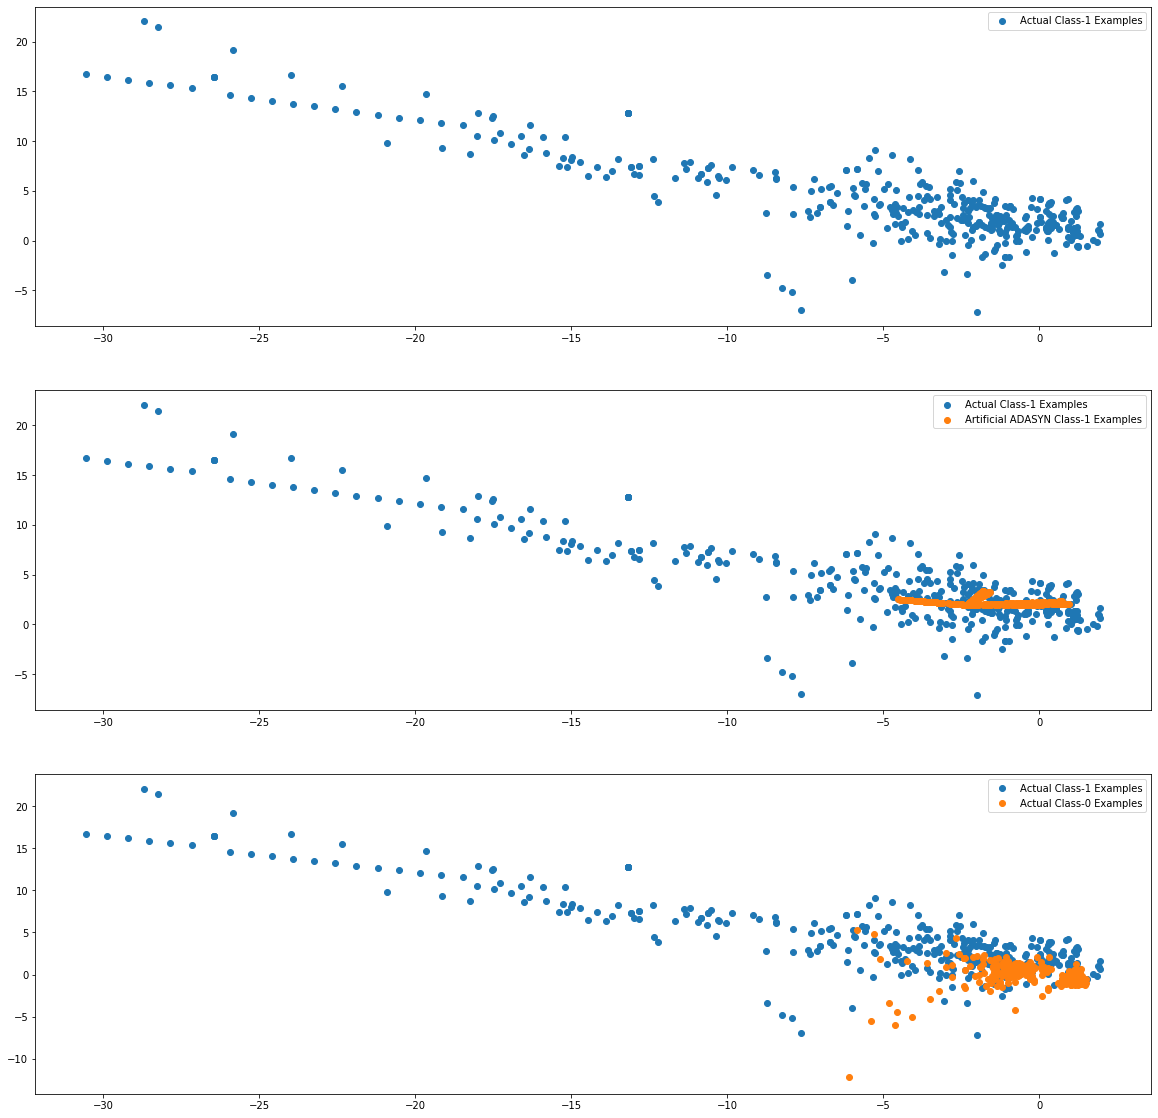

In [37]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train.to_numpy(), y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9930151102630809
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[ 0.77295757  0.70990421  0.68902821  0.93855483  0.49724146 -0.93775359
  -0.69715883 -0.50698416 -0.42307775 -0.9203155   0.61747023 -1.25029138
  -0.23831484 -1.52850075  0.12543275 -0.78244993 -0.84419144 -0.43412921
   0.22164307 -1.0838067  -0.02377885  0.56559503  0.40536936 -0.91706871
   0.50649814  0.03393942 -0.1820728   0.84938997  0.00904192  0.0110326 ]]
[-5.30146186]
{1: array([[0.64927751, 0.78559745, 0.91748425, 0.96520455, 0.98466299,
        0.98956394, 0.99070011, 0.99160716, 0.99195991, 0.99205746,
        0.99206947, 0.99206947, 0.99206947, 0.99206947, 0.99206947,
        0.99206947, 0.99206947, 0.99206947, 0.99206947, 0.99206947],
       [0.6460276 , 0.7845671 , 0.91904908, 0.96766046, 0.98636753,
        0.99079354, 0.99182711, 0.99273088, 0.99311463, 0.9932076 ,
        0.99322267, 0.99322267, 0.99322267, 0.99322267

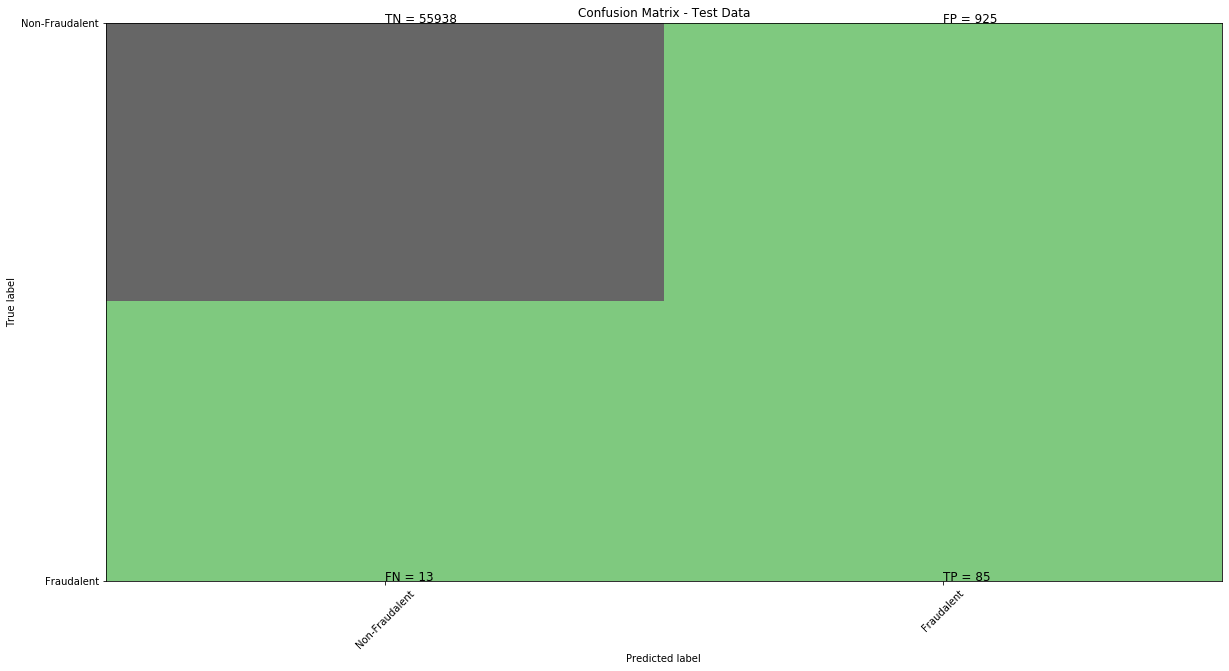

classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.08      0.87      0.15        98

    accuracy                           0.98     56961
   macro avg       0.54      0.93      0.57     56961
weighted avg       1.00      0.98      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


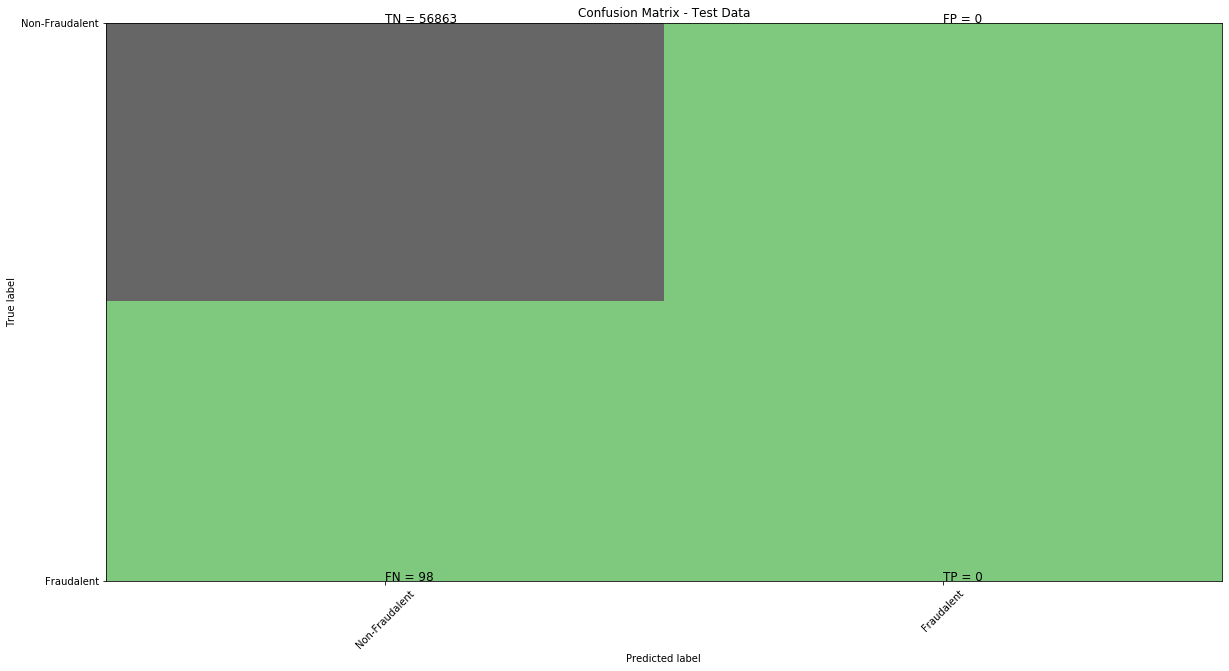

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.974585801821564
l2 threshold: 0.39391725732817195
ROC for the test dataset 97.5%


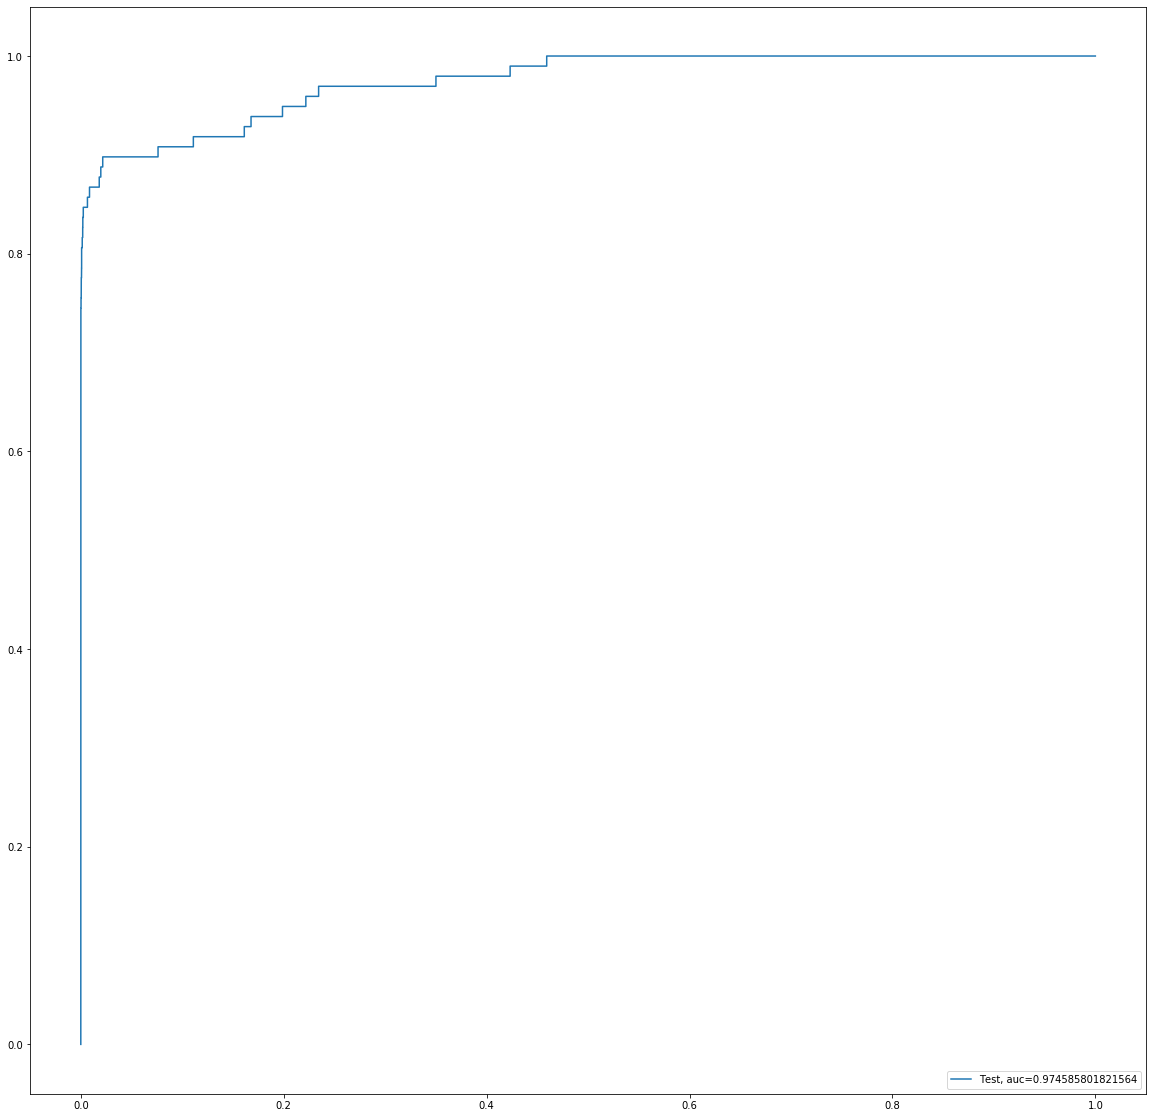

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


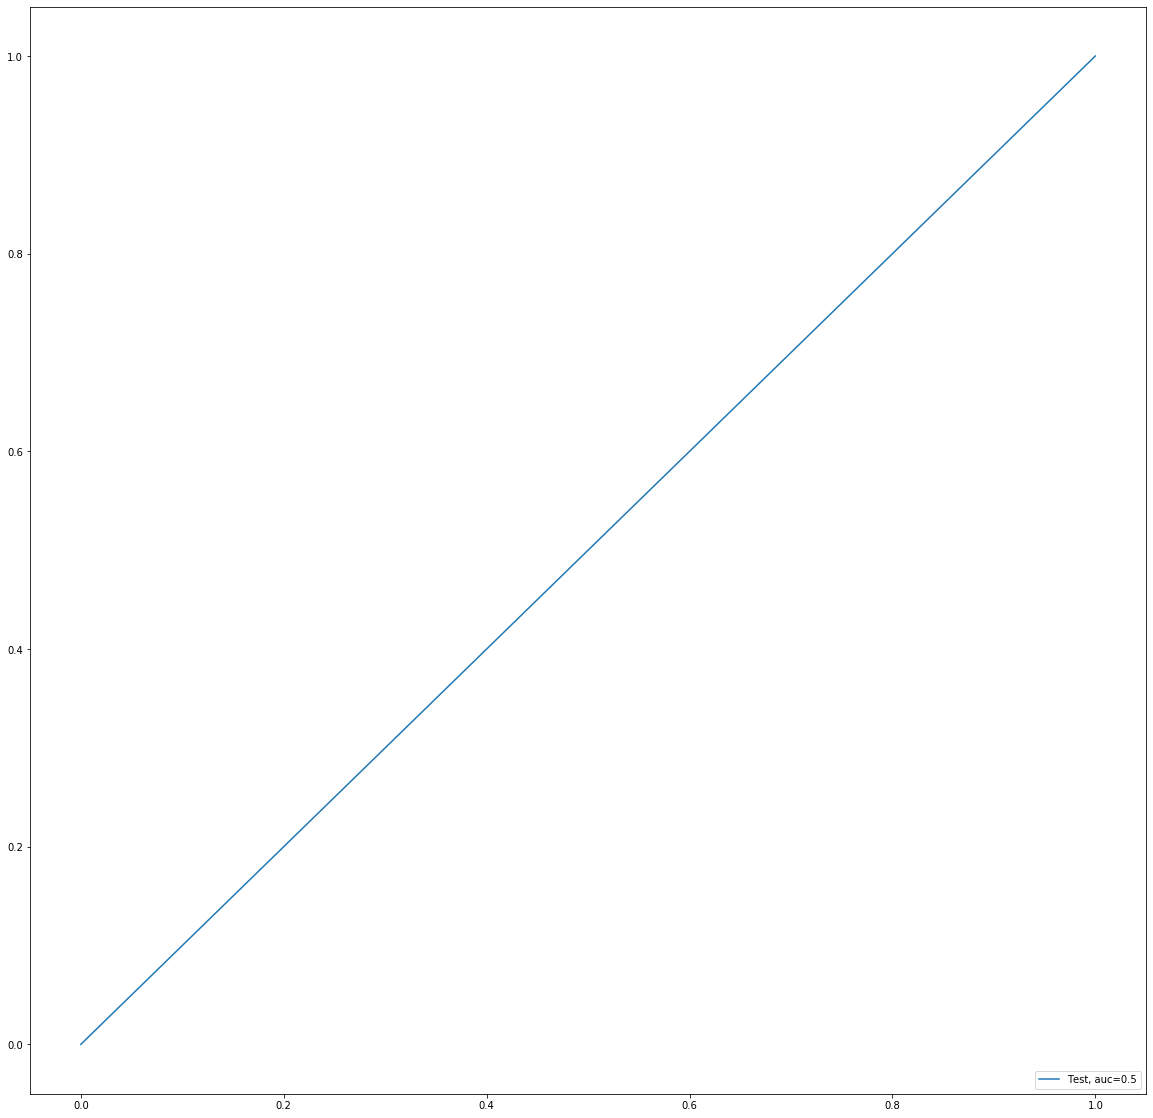

Time Taken by Model: --- 429.9248650074005 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9977528484401608
Confusion Matrix


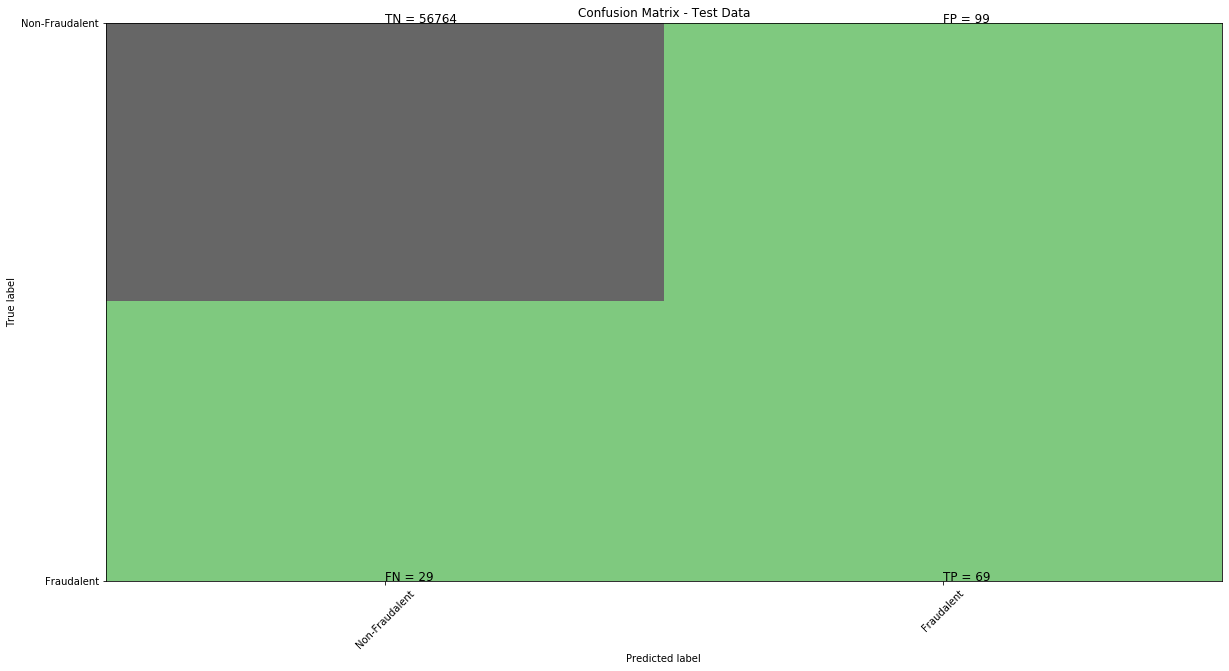

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.41      0.70      0.52        98

    accuracy                           1.00     56961
   macro avg       0.71      0.85      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8511703029874526
Tree threshold: 1.0
ROC for the test dataset 85.1%


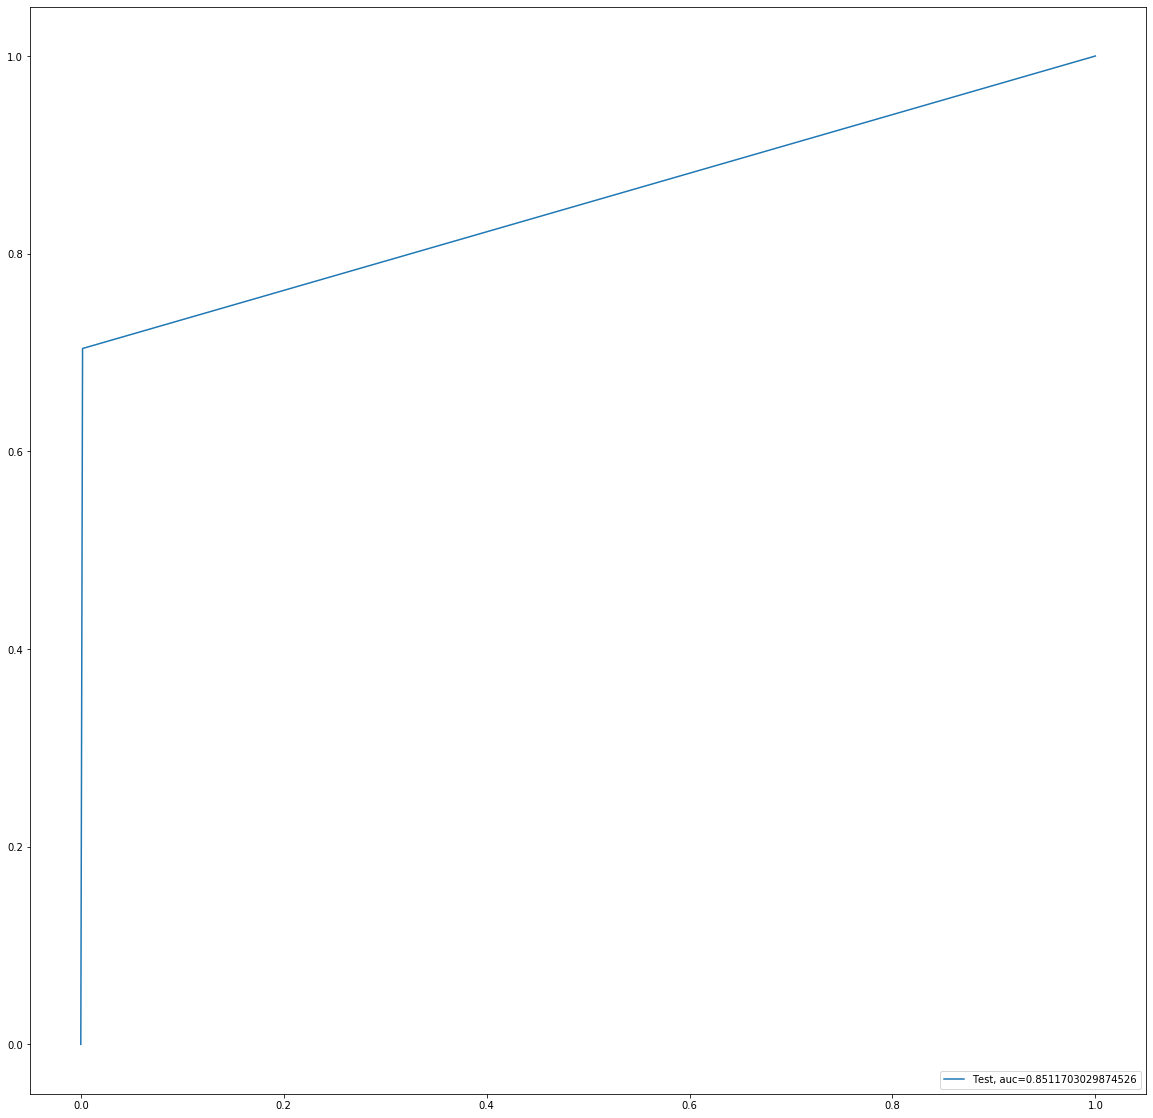

entropy score: 0.9969803900914661
Confusion Matrix


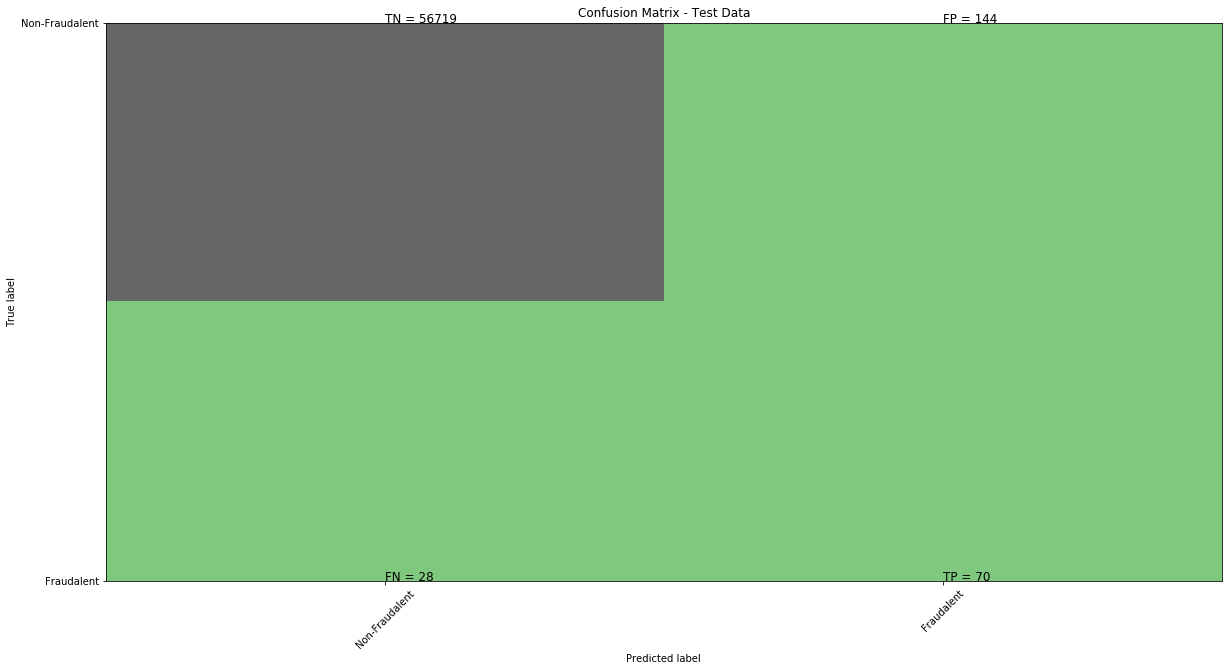

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.33      0.71      0.45        98

    accuracy                           1.00     56961
   macro avg       0.66      0.86      0.72     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8558766559223799
Tree threshold: 1.0
ROC for the test dataset 85.6%


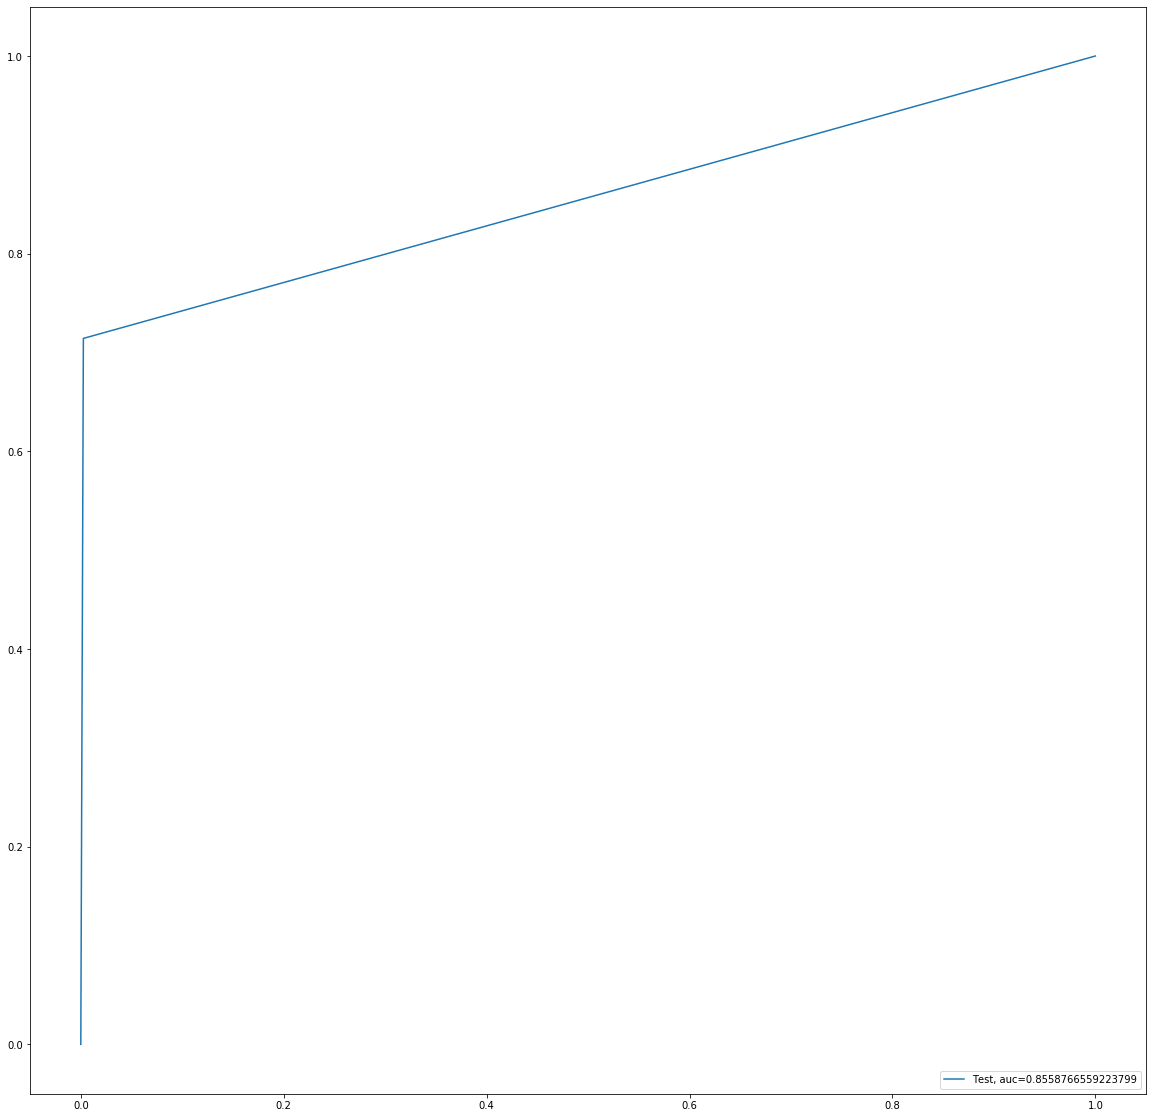

Time Taken by Model: --- 64.91979217529297 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


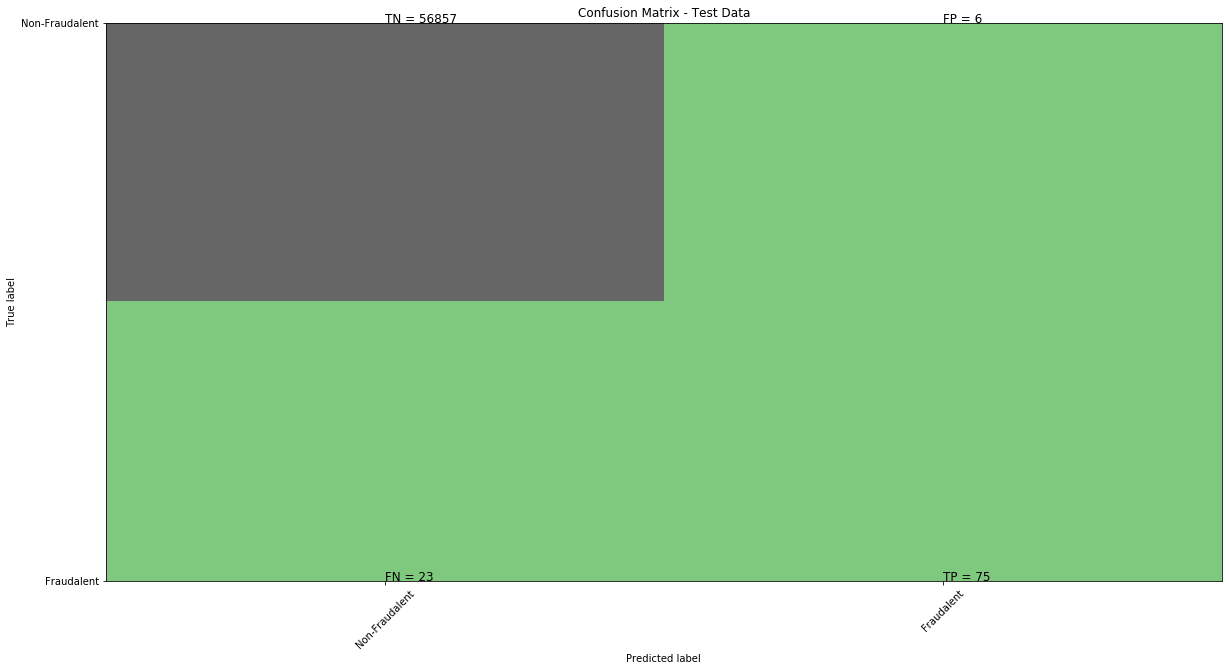

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9614705879186172
Random Forest threshold: 0.05
ROC for the test dataset 96.1%


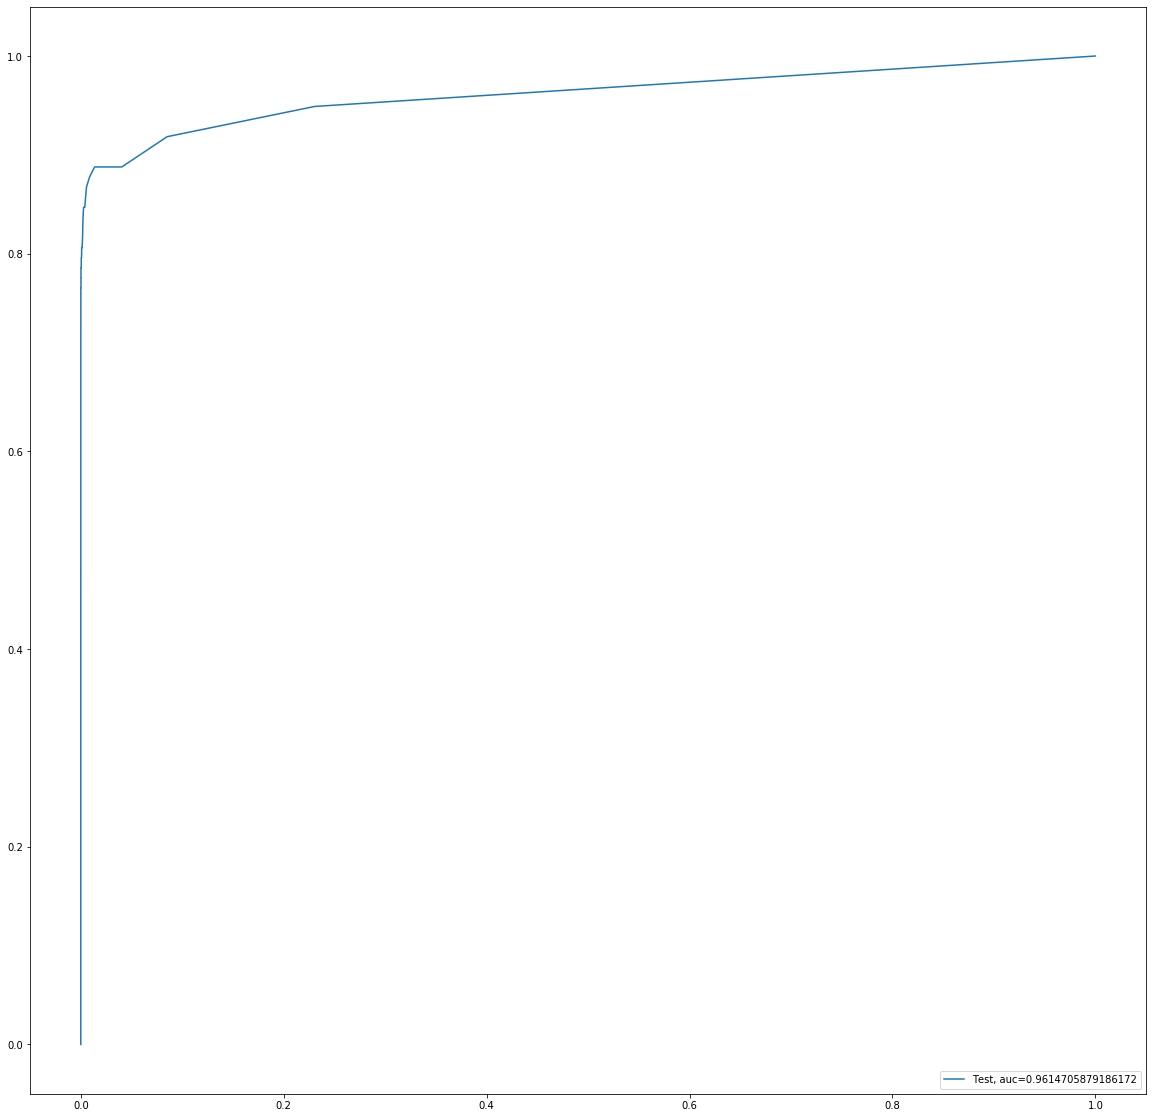

Time Taken by Model: --- 311.7417743206024 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
[21:57:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9994382121100402
Confusion Matrix


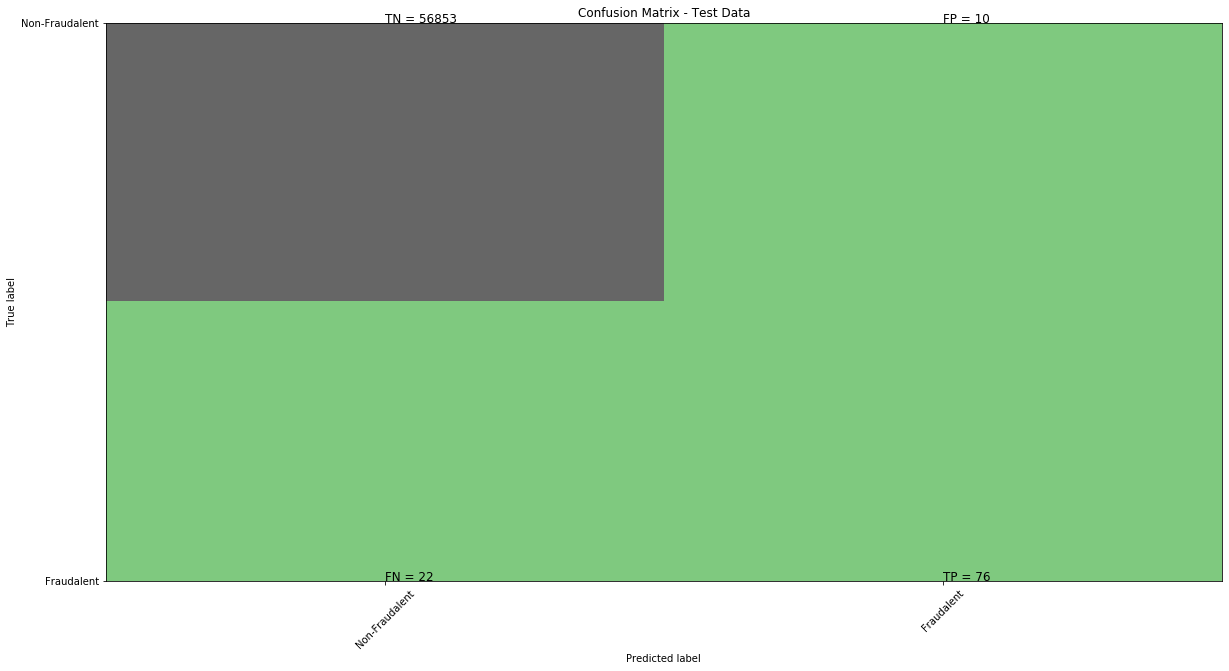

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.78      0.83        98

    accuracy                           1.00     56961
   macro avg       0.94      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9741530574560336
XGBoost threshold: 0.00022058551257941872
ROC for the test dataset 97.4%


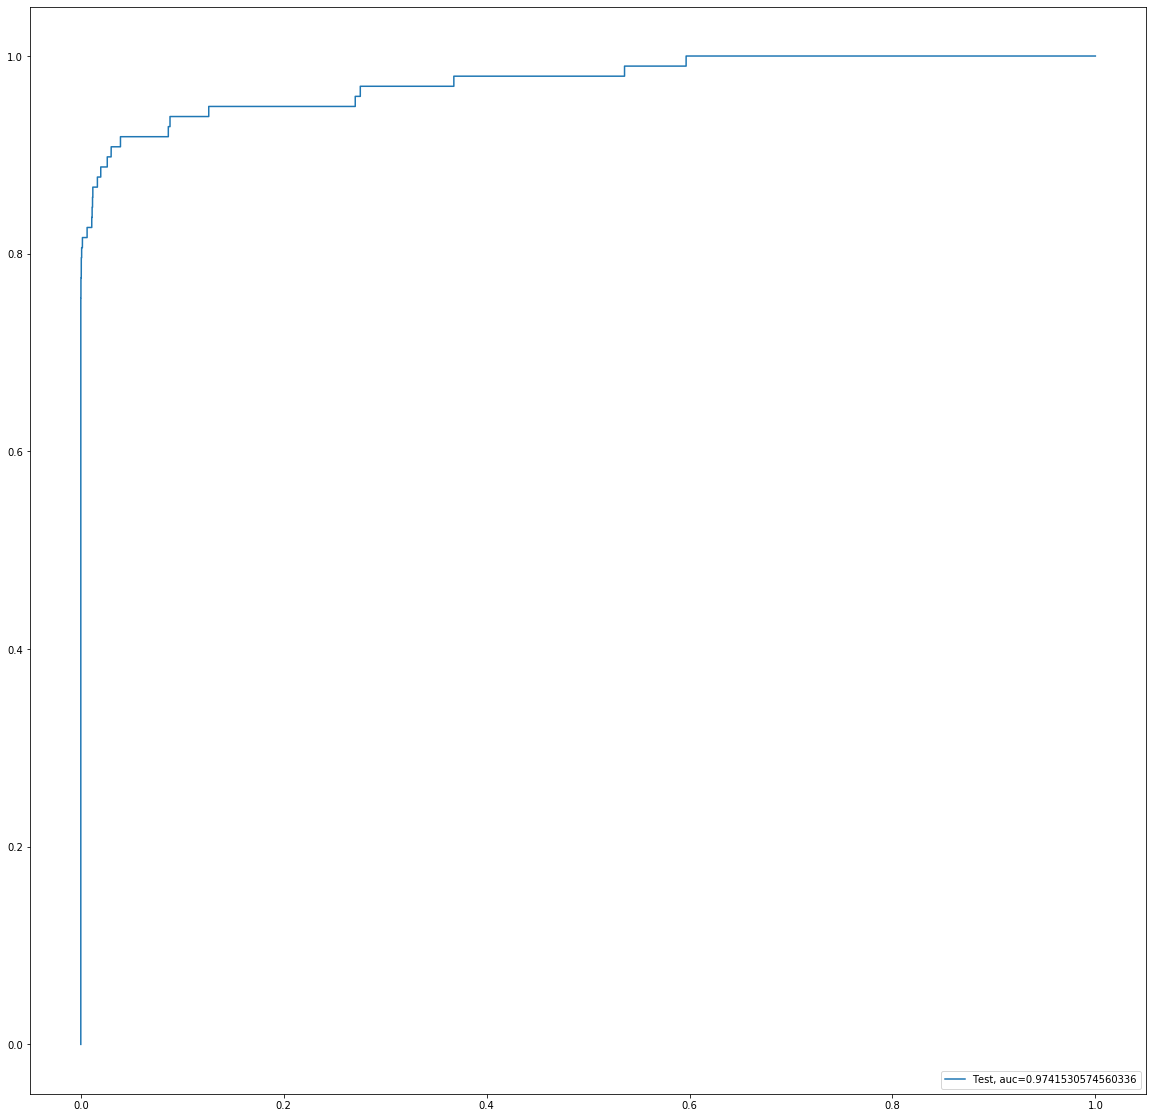

Time Taken by Model: --- 92.99697875976562 seconds ---
--------------------------------------------------------------------------------


In [38]:
Data_Imbalance_Handiling	 = "SMOTE Oversampling with StratifiedKFold CV "
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run KNN Model

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )


In [39]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.998999,0.966806,0.001289
1,Power Transformer,Logistic Regression with L1 Regularisation,0.998841,0.963903,0.009276
2,Power Transformer,Tree Model with gini criteria,0.998806,0.859015,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999052,0.864337,1.000000
4,Power Transformer,Random Forest,0.999350,0.940564,0.010000
5,Power Transformer,XGBoost,0.999456,0.972998,0.000051
6,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983314,0.001575
7,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087
8,StratifiedKFold Cross Validation,Tree Model with gini criteria,0.998841,0.826249,1.000000
9,StratifiedKFold Cross Validation,Tree Model with entropy criteria,0.999017,0.821244,1.000000


##### Build models on other algorithms to see the better performing on ADASYN

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

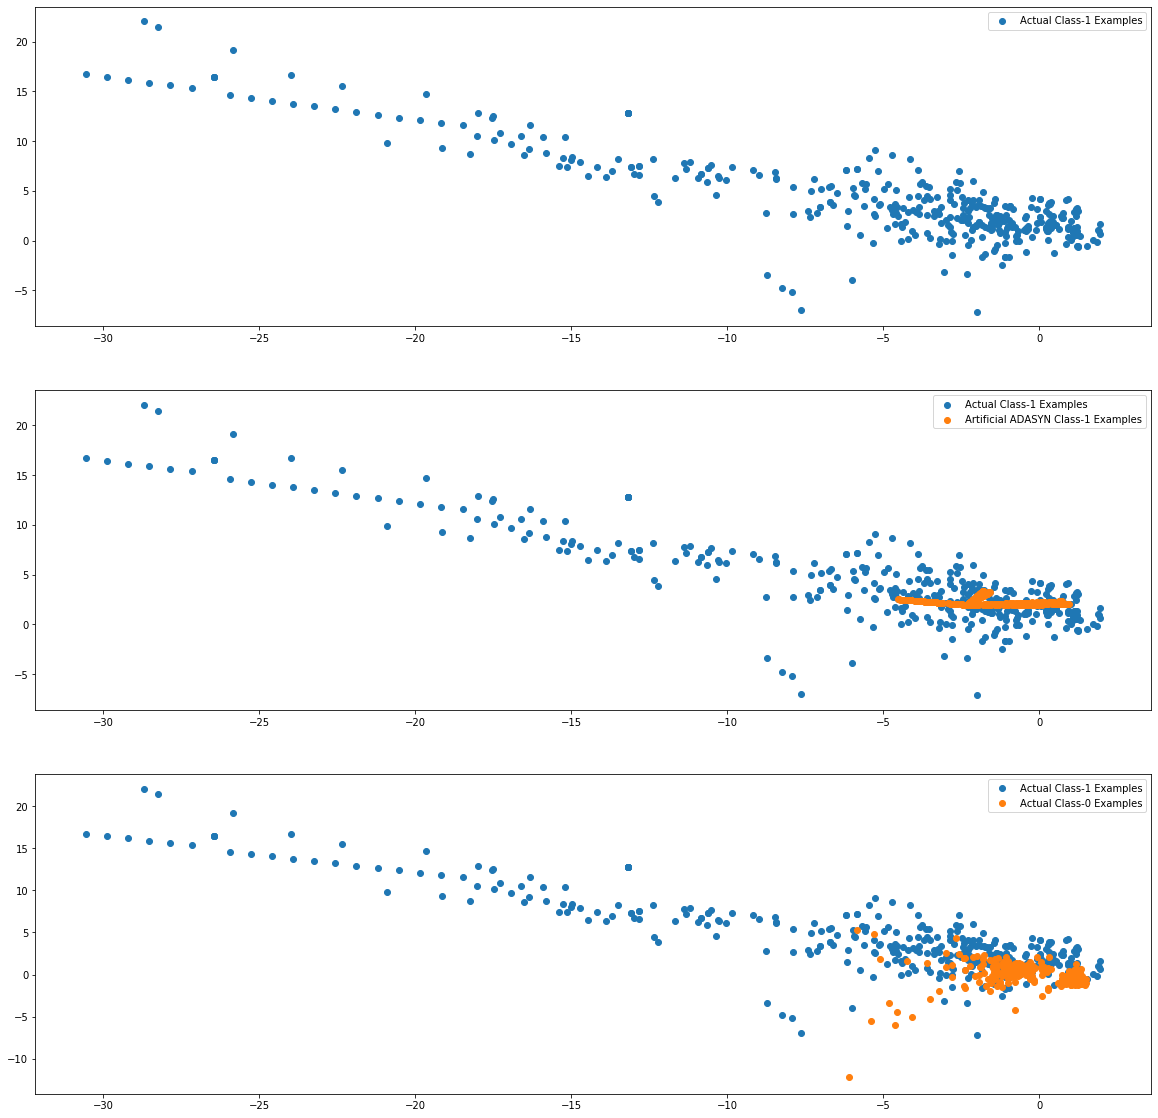

In [40]:
from imblearn import over_sampling

ADASYN = over_sampling.ADASYN(random_state=0)
X_train_ADASYN, y_train_ADASYN = ADASYN.fit_resample(X_train.to_numpy(), y_train) 

# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_ADASYN[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [41]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    SMOTE = over_sampling.SMOTE(random_state=0)
    X_train_ADASYN, y_train_ADASYN= ADASYN.fit_resample(X_train, y_train)
  
#Create Dataframe for X_over
X_train_ADASYN = pd.DataFrame(data=X_train_ADASYN,   columns=cols)

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9835140286818707
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[ 0.99403285  1.05973585  0.87043655  0.95041203  0.76738237 -1.2021895
  -0.94633089 -0.58445013 -0.3626884  -0.88754235  0.79262732 -1.45312942
  -0.16504075 -1.99238629  0.14403211 -1.00138565 -1.14683259 -0.52949296
   0.38453996 -1.41752899 -0.20527626  0.71927336  0.65827733 -1.11493395
   0.71547526  0.20893683  0.1497919   1.32917014  0.01286232  0.02229584]]
[-5.11904973]
{1: array([[0.610404  , 0.63191849, 0.72150467, 0.87081578, 0.95798817,
        0.97416661, 0.97844939, 0.98148612, 0.98276938, 0.98315331,
        0.98321611, 0.98321611, 0.98321611, 0.98321611, 0.98321611,
        0.98321611, 0.98321611, 0.98321611, 0.98321611, 0.98321611],
       [0.61072194, 0.63192858, 0.72000917, 0.86805623, 0.95677094,
        0.9739103 , 0.97856472, 0.98179989, 0.98312689, 0.98350013,
        0.98355615, 0.98355615, 0.98355615, 0.98355615,

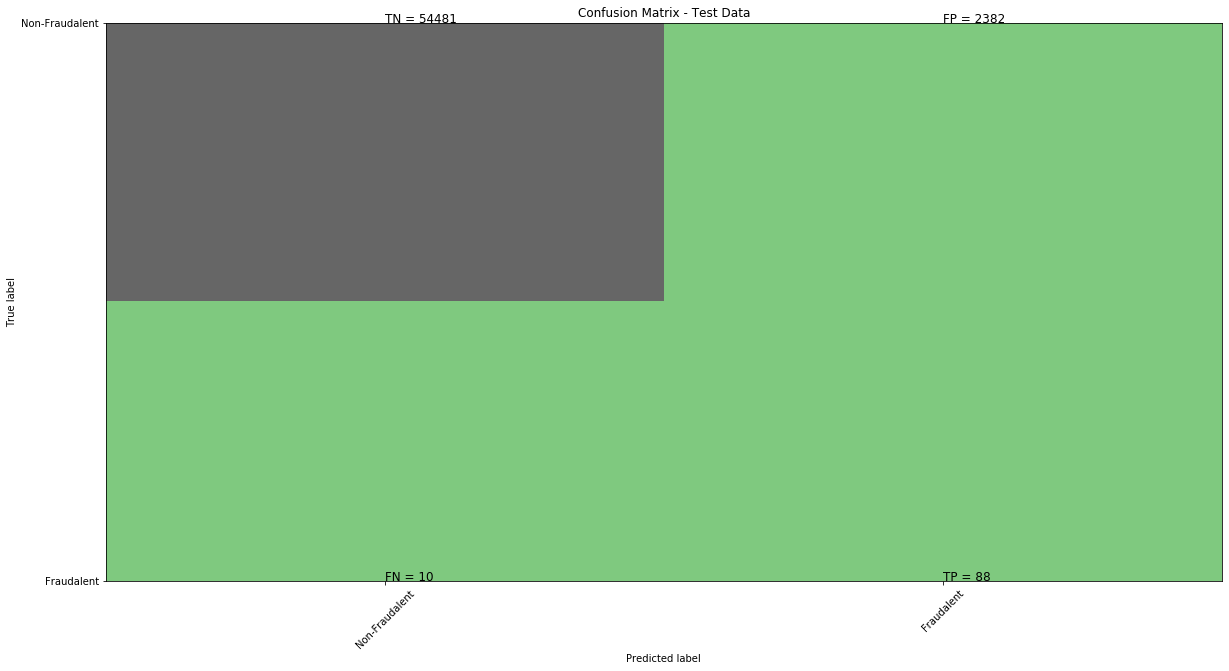

classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.90      0.07        98

    accuracy                           0.96     56961
   macro avg       0.52      0.93      0.52     56961
weighted avg       1.00      0.96      0.98     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


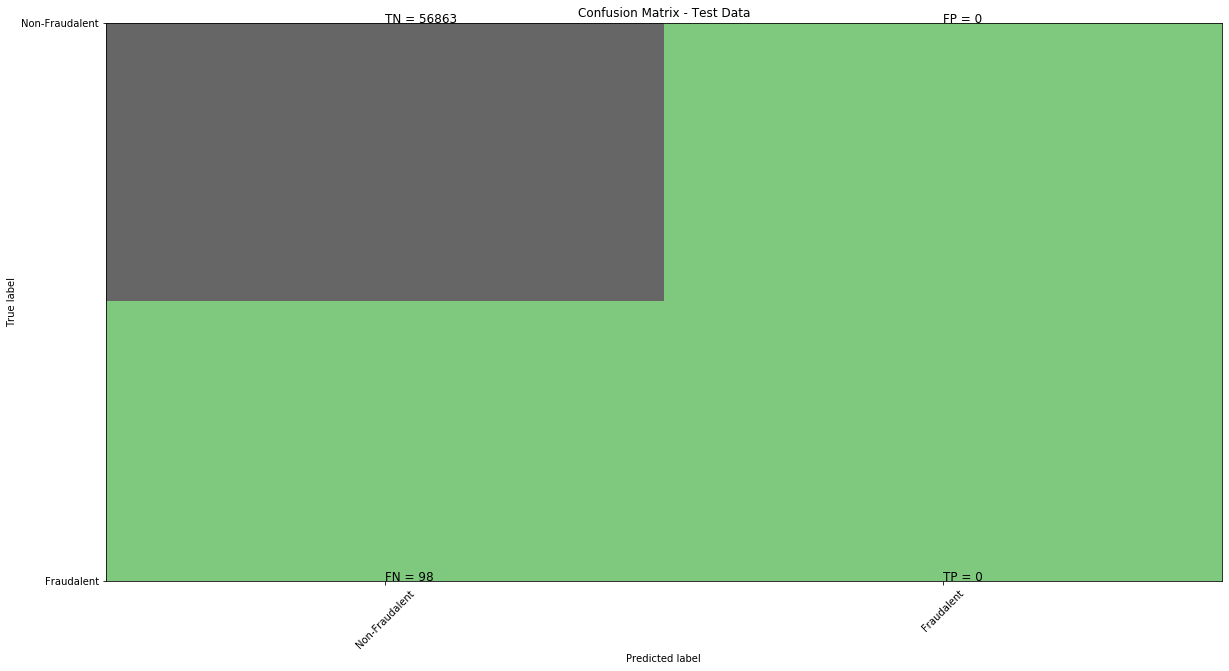

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9740196361681334
l2 threshold: 0.611486014322536
ROC for the test dataset 97.4%


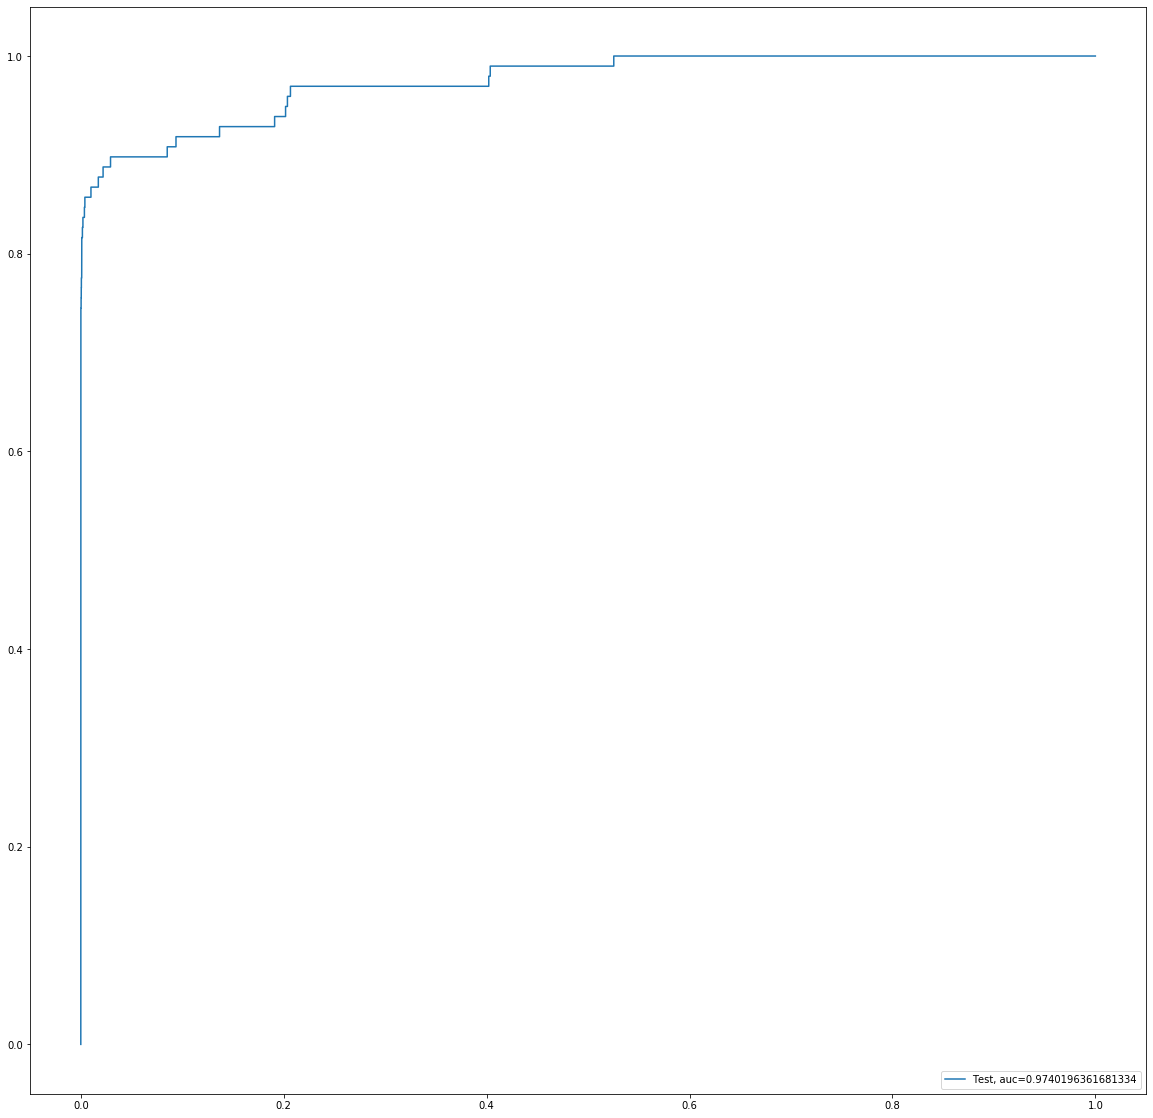

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


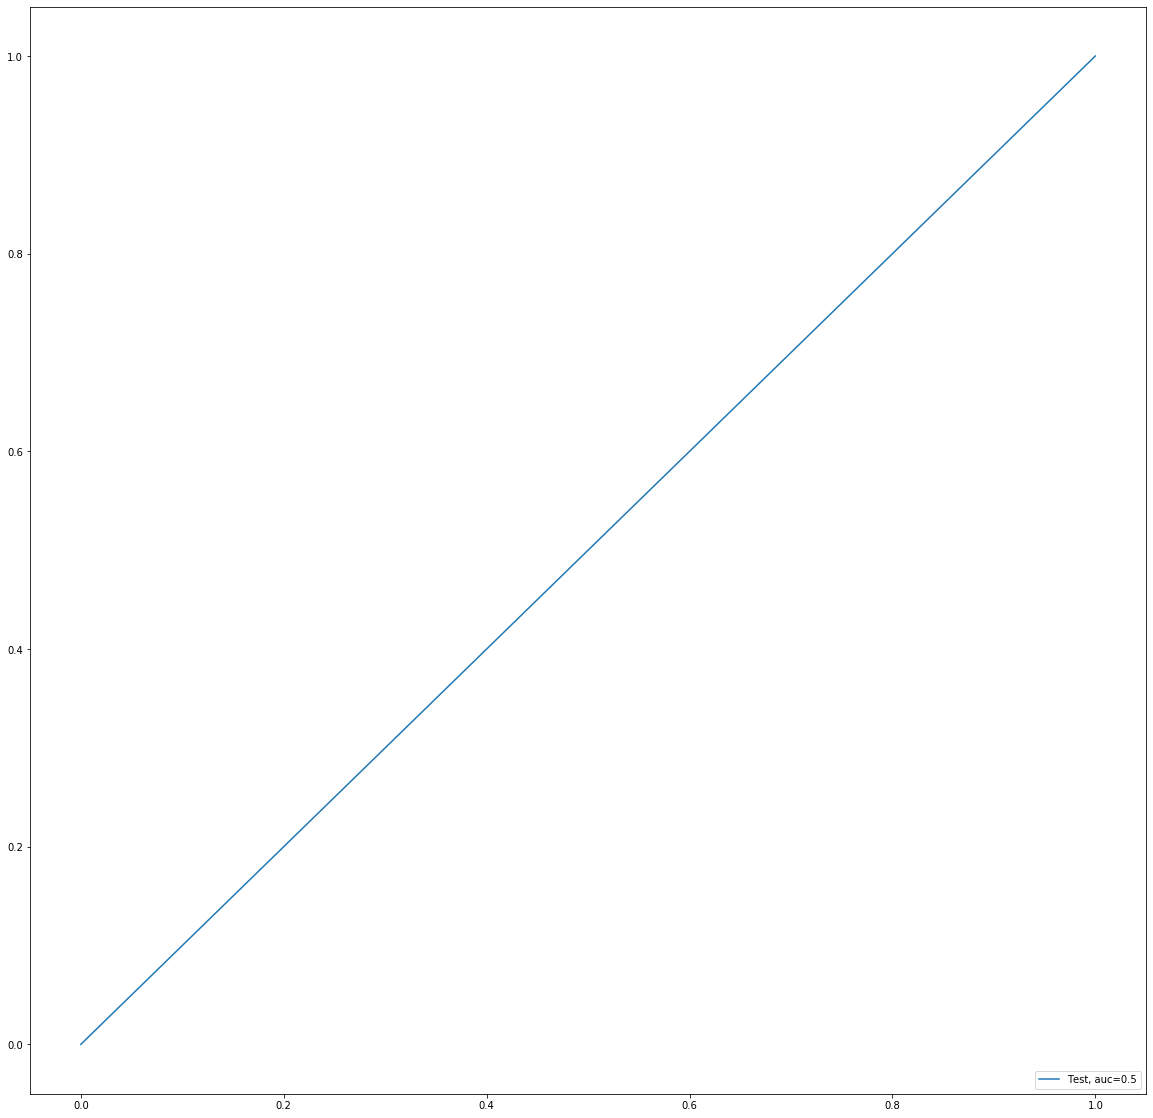

Time Taken by Model: --- 483.8030643463135 seconds ---
--------------------------------------------------------------------------------
Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9979459630273345
Confusion Matrix


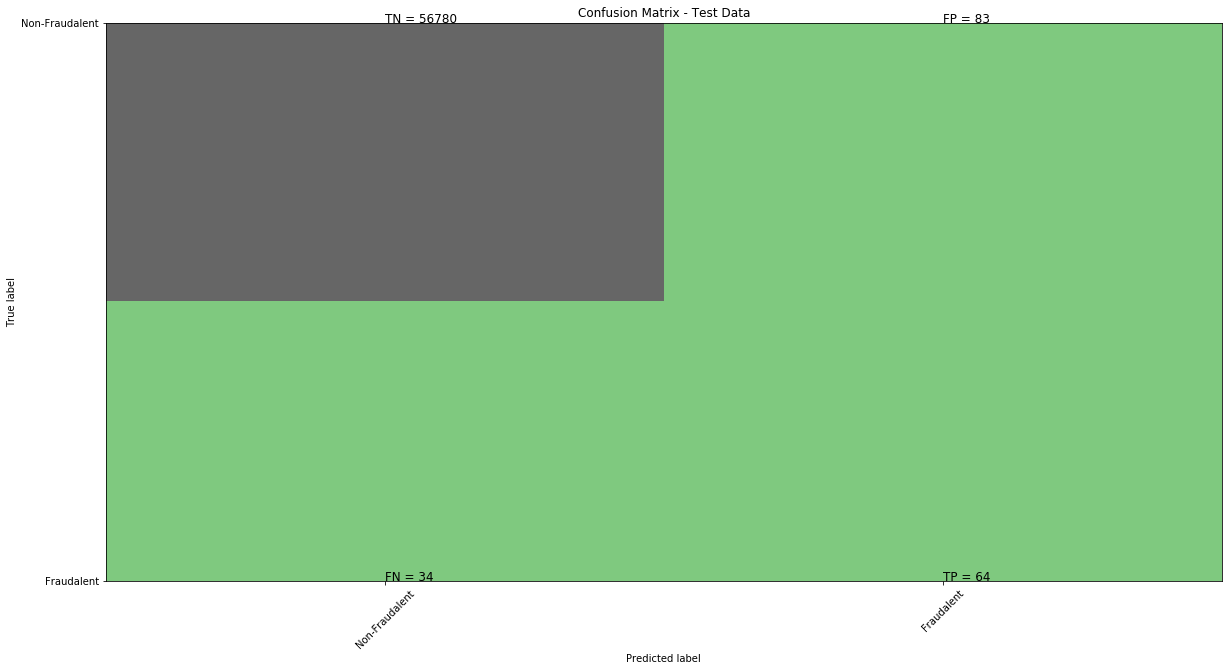

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.44      0.65      0.52        98

    accuracy                           1.00     56961
   macro avg       0.72      0.83      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8258007879303172
Tree threshold: 1.0
ROC for the test dataset 82.6%


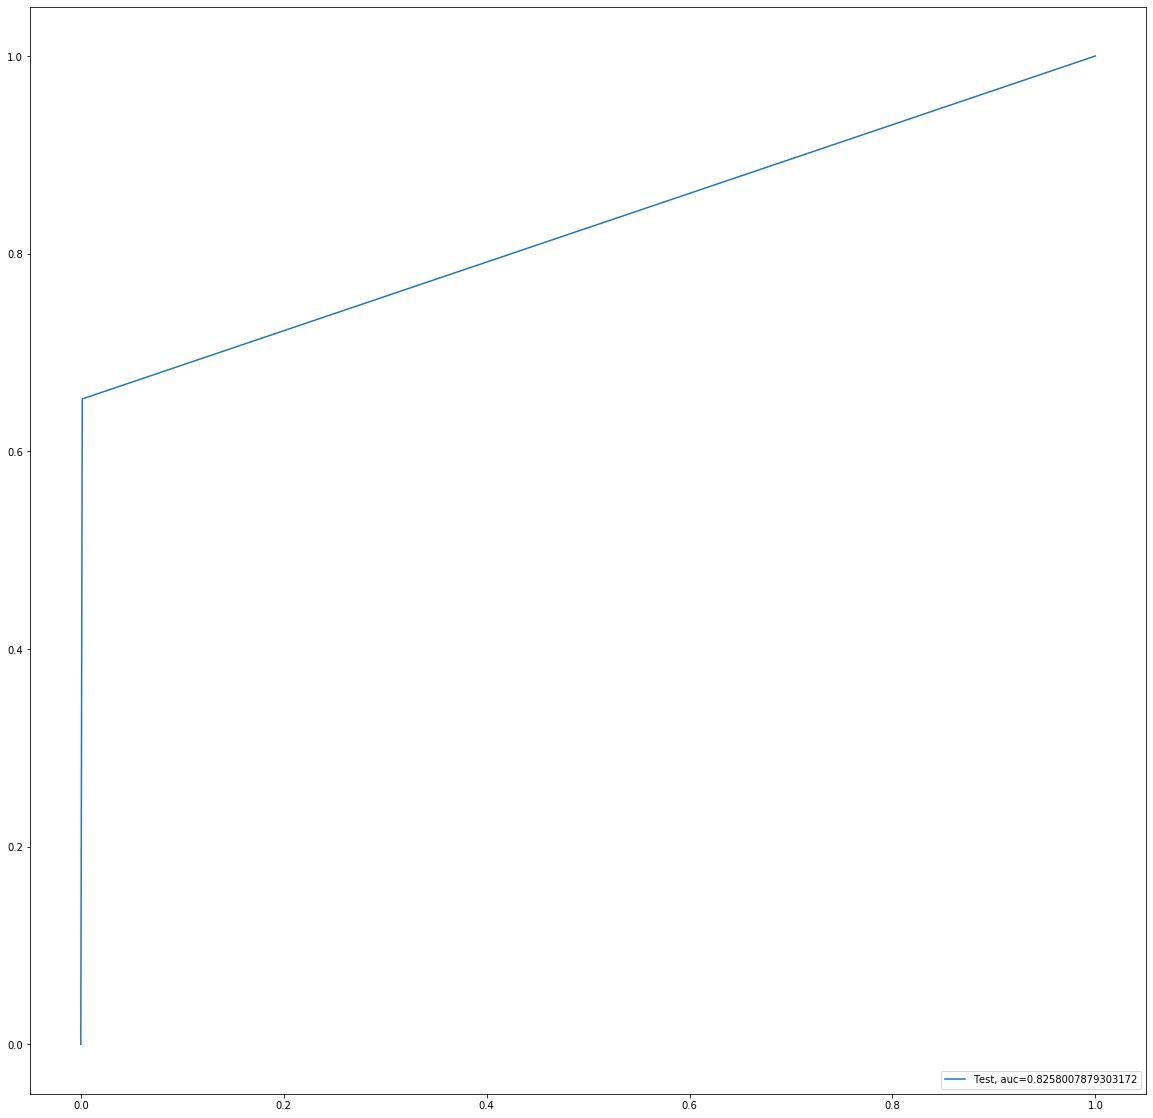

entropy score: 0.9954179175225154
Confusion Matrix


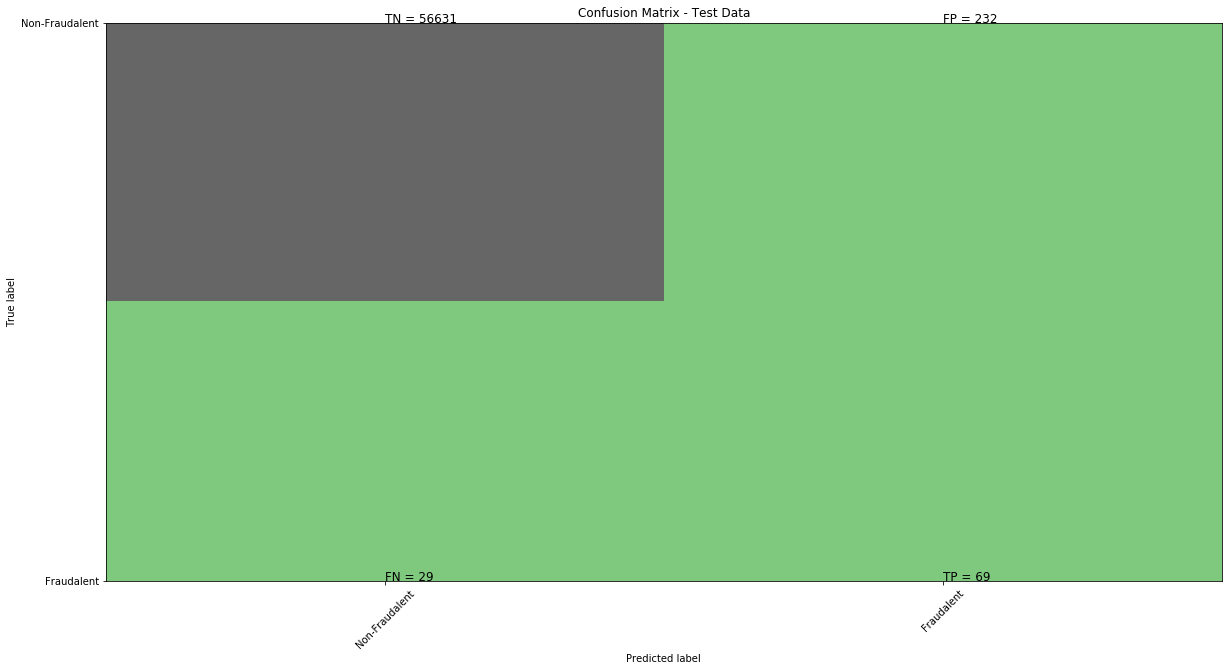

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.23      0.70      0.35        98

    accuracy                           1.00     56961
   macro avg       0.61      0.85      0.67     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8500008254713172
Tree threshold: 1.0
ROC for the test dataset 85.0%


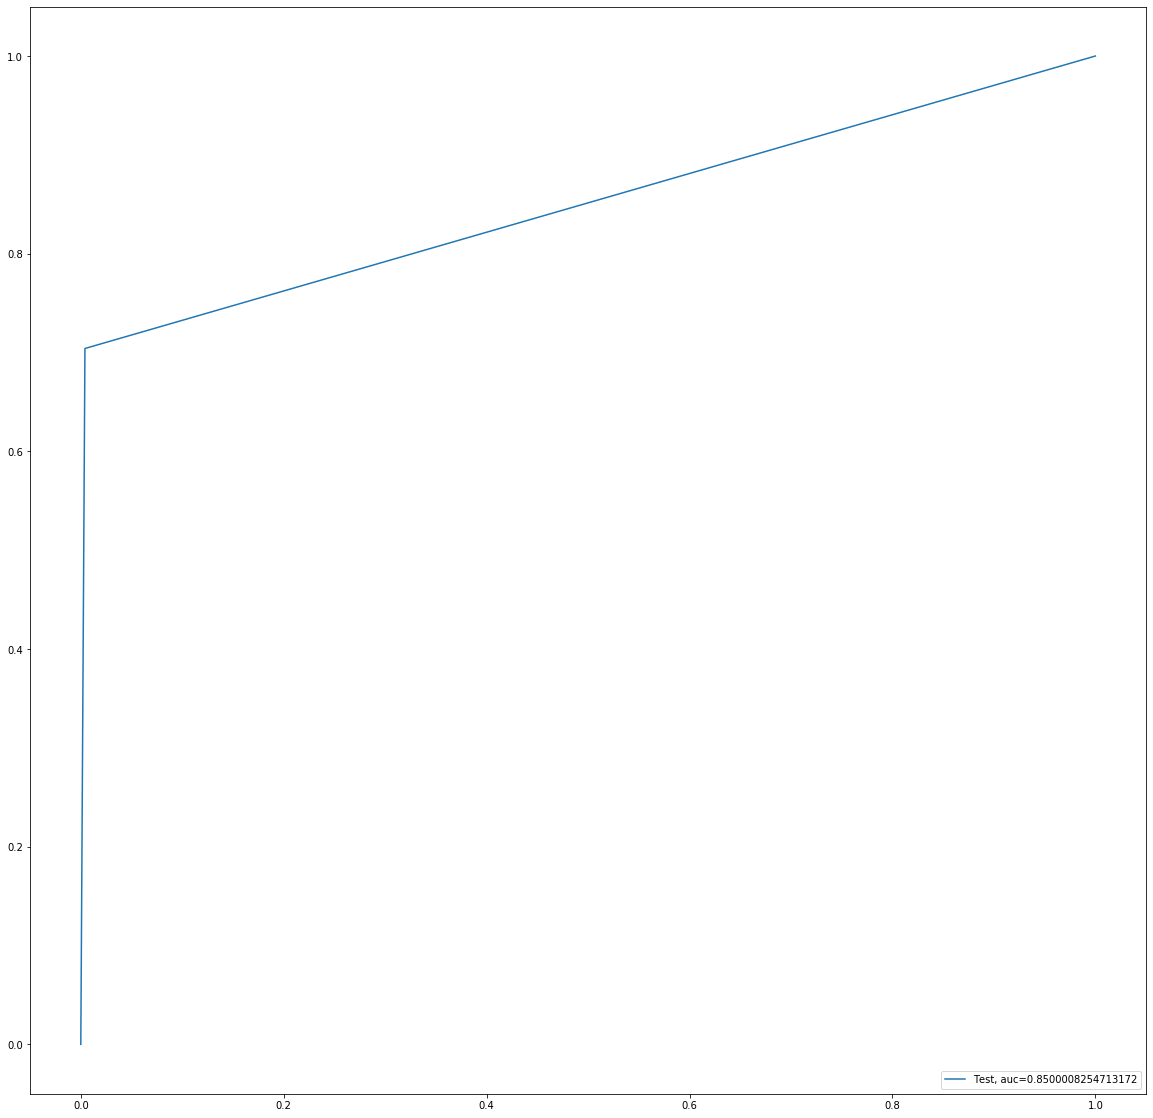

Time Taken by Model: --- 65.81032919883728 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995259914678464
Confusion Matrix


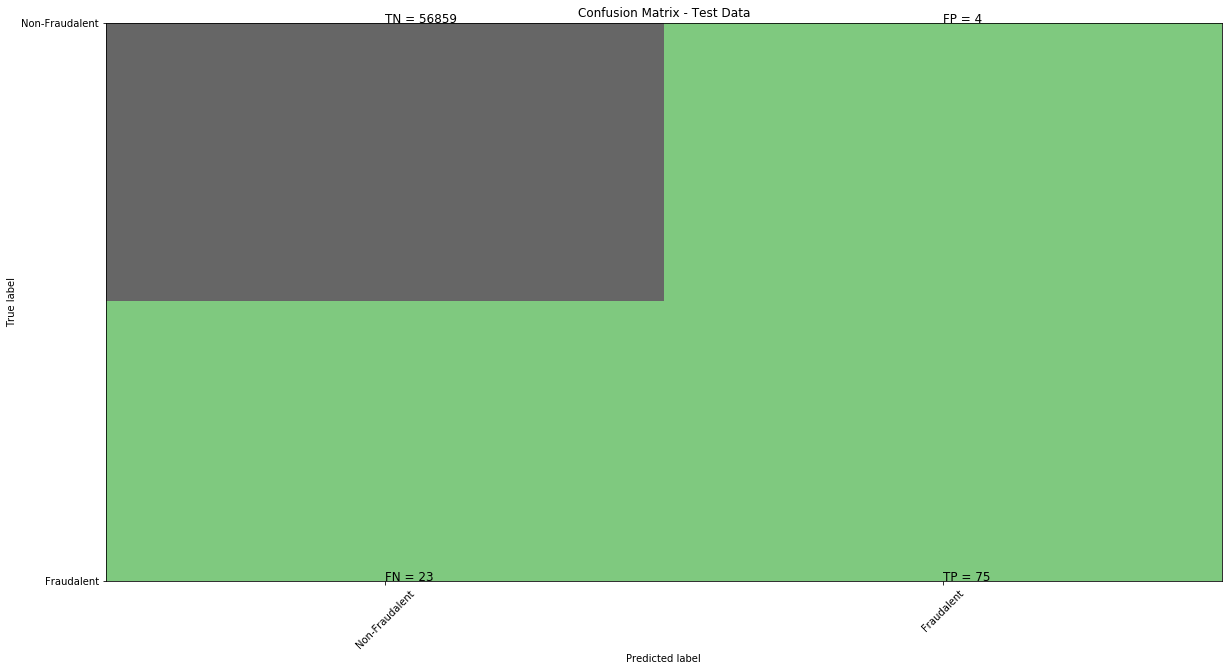

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56961
   macro avg       0.97      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9632269575962563
Random Forest threshold: 0.03
ROC for the test dataset 96.3%


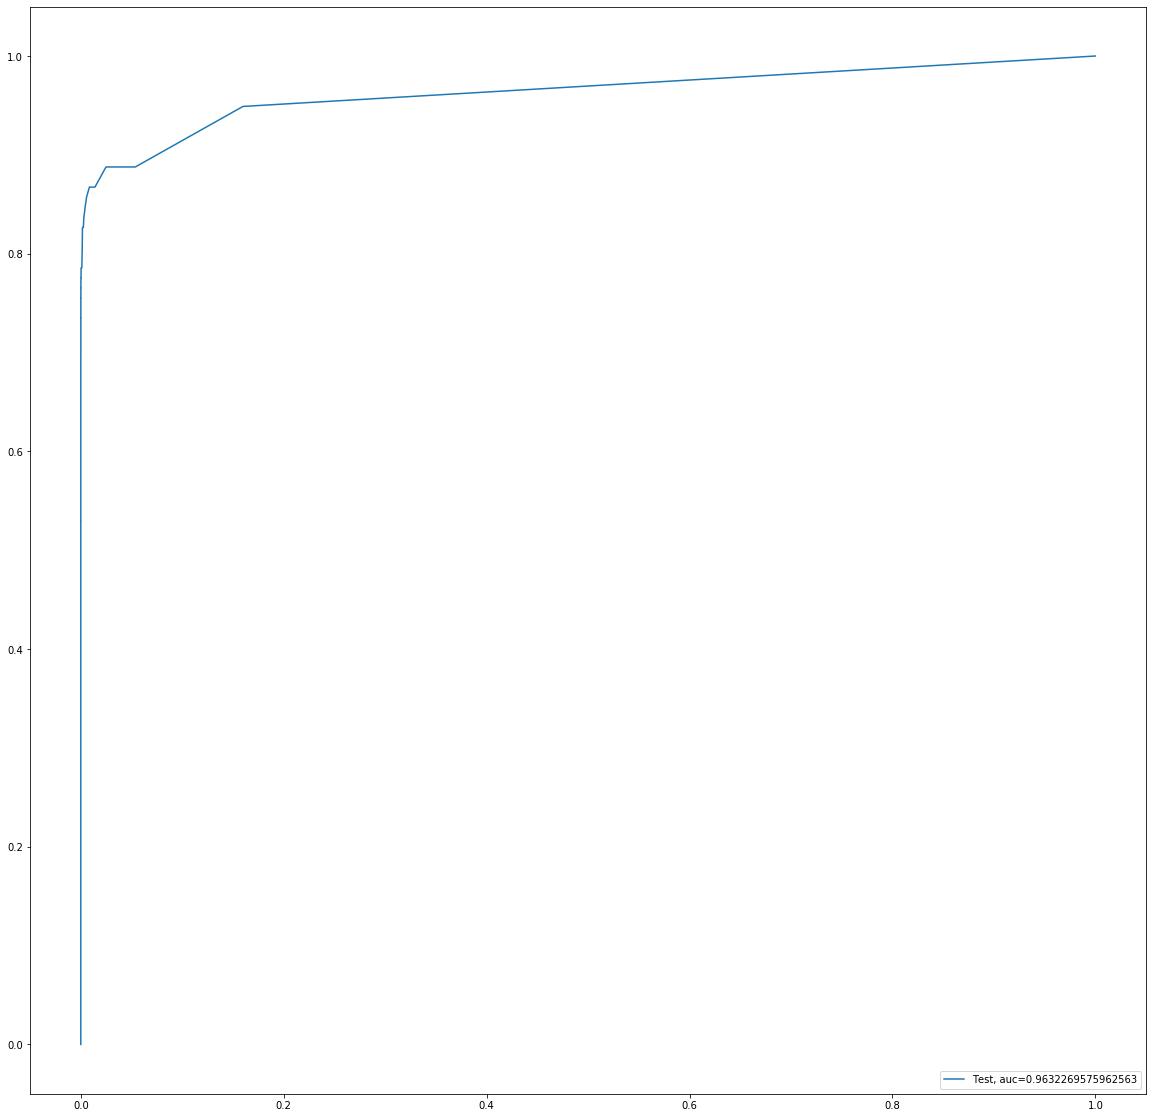

Time Taken by Model: --- 329.3582146167755 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
[22:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9993855444953564
Confusion Matrix


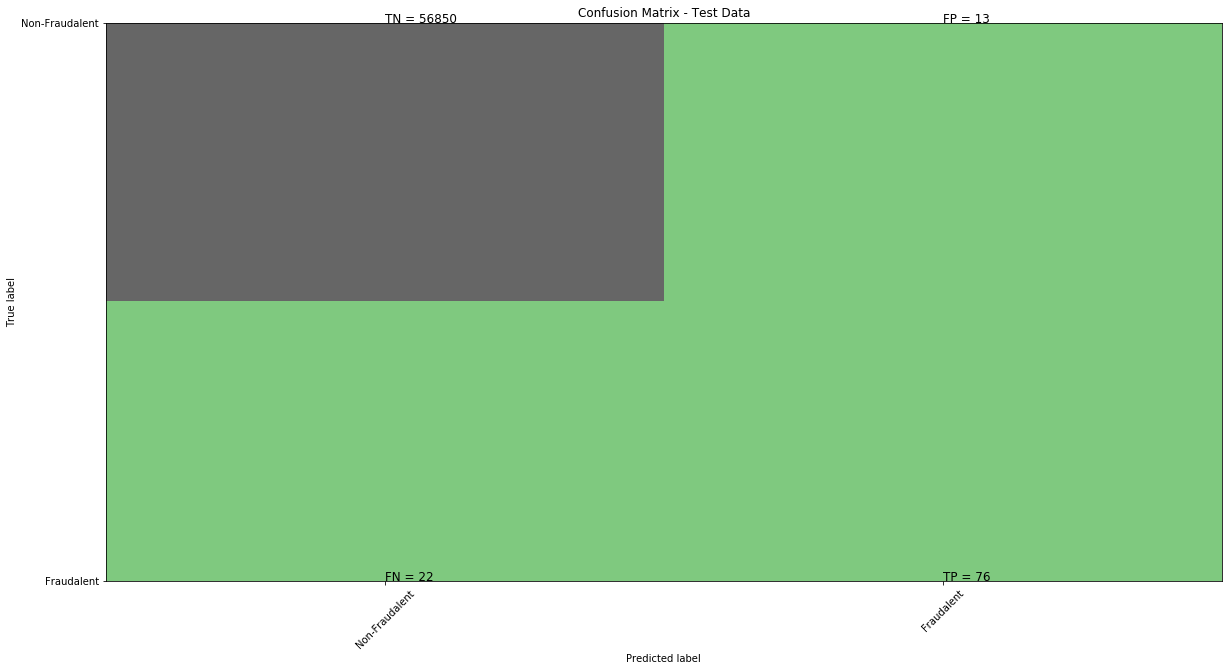

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.85      0.78      0.81        98

    accuracy                           1.00     56961
   macro avg       0.93      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.970320537690482
XGBoost threshold: 0.0016991241136565804
ROC for the test dataset 97.0%


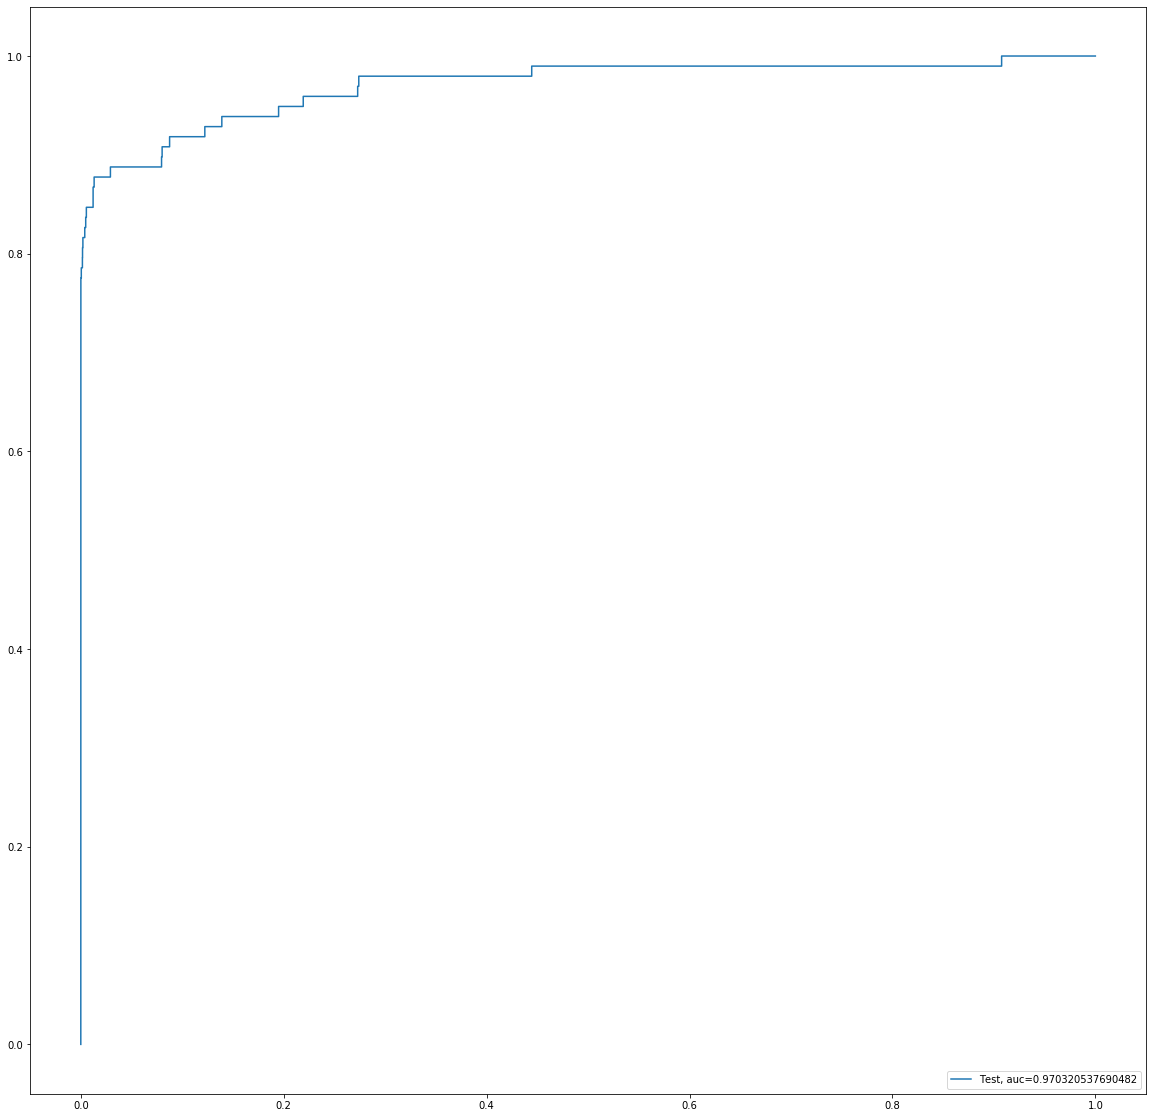

Time Taken by Model: --- 113.08733105659485 seconds ---
--------------------------------------------------------------------------------


In [42]:
Data_Imbalance_Handiling	 = "ADASYN Oversampling with StratifiedKFold CV "
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, Data_Imbalance_Handiling, X_train_ADASYN, y_train_ADASYN , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results, Data_Imbalance_Handiling,X_train_ADASYN, y_train_ADASYN , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, Data_Imbalance_Handiling,X_train_ADASYN, y_train_ADASYN , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, Data_Imbalance_Handiling,X_train_ADASYN, y_train_ADASYN , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )


In [43]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.998999,0.966806,0.001289
1,Power Transformer,Logistic Regression with L1 Regularisation,0.998841,0.963903,0.009276
2,Power Transformer,Tree Model with gini criteria,0.998806,0.859015,1.000000
3,Power Transformer,Tree Model with entropy criteria,0.999052,0.864337,1.000000
4,Power Transformer,Random Forest,0.999350,0.940564,0.010000
5,Power Transformer,XGBoost,0.999456,0.972998,0.000051
6,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.998771,0.983314,0.001575
7,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087
8,StratifiedKFold Cross Validation,Tree Model with gini criteria,0.998841,0.826249,1.000000
9,StratifiedKFold Cross Validation,Tree Model with entropy criteria,0.999017,0.821244,1.000000


#Parameter Tuning for Final Model by Handling class imbalance

In [44]:
#Evaluate XGboost model
from xgboost import XGBClassifier
# fit model no training data
XGBmodel = XGBClassifier(random_state=42)
XGBmodel.fit(X_over, y_over)

XGB_test_score = XGBmodel.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

[22:15:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9994733238531627
XGboost roc_value: 0.9851709461372787
XGBoost threshold: 6.0486792790470645e-05


In [45]:
#Evaluate XGboost model
from xgboost import XGBClassifier
# fit model no training data
XGBmodel = XGBClassifier(random_state=42)


In [ ]:
#Lets tune XGBoost Model for max_depth and min_child_weight
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
         param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'n_estimators':range(60,150,20)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4,cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
# We will narrow down the tunned parameters of max_depth ,  min_child_weight and n_estimators
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'n_estimators':[110,120,130],
  'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4,cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
#With 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 130 parameters tuned above we will now check learning rate

# We will narrow down the tunned parameters of max_depth ,  min_child_weight and n_estimators
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'learning_rate':[0.05,0.1,0.125,0.15,0.2]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
#With 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 130 parameters tuned above we will now check learning rate

# We will narrow down the tunned parameters of max_depth ,  min_child_weight and n_estimators
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
#Evaluate XGboost model
from xgboost import XGBClassifier
# fit model no training data
XGBmodel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
XGBmodel.fit(X_over, y_over)

XGB_test_score = XGBmodel.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

In [ ]:
#With 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 130 , gamma: 0.1 parameters tuned above we will now check learning rate

# We will narror down the tunned parameters of max_depth ,  min_child_weight and n_estimators
#Lets tune XGBoost Model for n_estimators
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
param_test = {
 'subsample':[i/10.0 for i in range(7,10)],
 'colsample_bytree':[i/10.0 for i in range(7,10)]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
#Evaluate XGboost model
from xgboost import XGBClassifier
# fit model no training data
XGBmodel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
XGBmodel.fit(X_over, y_over)

XGB_test_score = XGBmodel.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

In [ ]:
# perform the best oversampling method on X_train & y_train

clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
clf.fit(X_over, y_over ) # fit on the balanced dataset
XGB_test_score = clf.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = clf.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

### Print the important features of the best model to understand the dataset

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [ ]:
# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))